In [1]:
#+- 15 min loading
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import gurobipy as gp

from datetime import datetime, timedelta
from shapely.ops import unary_union
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from dists import manhattan
from santiago_map import santiago_map # 14.9s
from demand import demand, kde # 12.8s
from sample_demand import idxs, edges_sample, nodes, D, r #9m
from graphs import DemandNode, Demand
from utils import feasible_paths, reachable_area, reachable_nodes
from Viajes_auto import Viajes_auto

c:\Users\benja\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\benja\OneDrive\Documentos\U\VarationsOnCoverage\Viajes_auto.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Viajes_auto['Manhattan'] = Viajes_auto['Manhattan'] / 1e3
c:\Users\benja\OneDrive\Documentos\U\VarationsOnCoverage\Viajes_auto.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [2]:
demand_ = Demand(D.apply(lambda x: DemandNode(O=x.O, D=x.D, f=x.f, tol=x.tol), axis=1).to_numpy())

## General plots

We don't consider the comunes with low vehicles density (<=10 Vehic./km2)

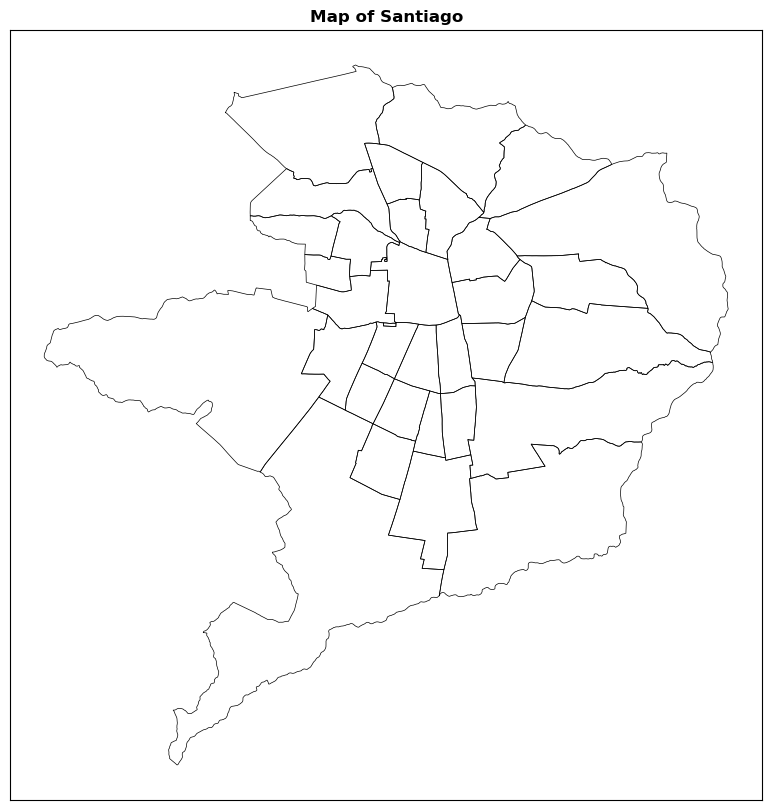

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
ax.set_title('Map of Santiago')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

[]

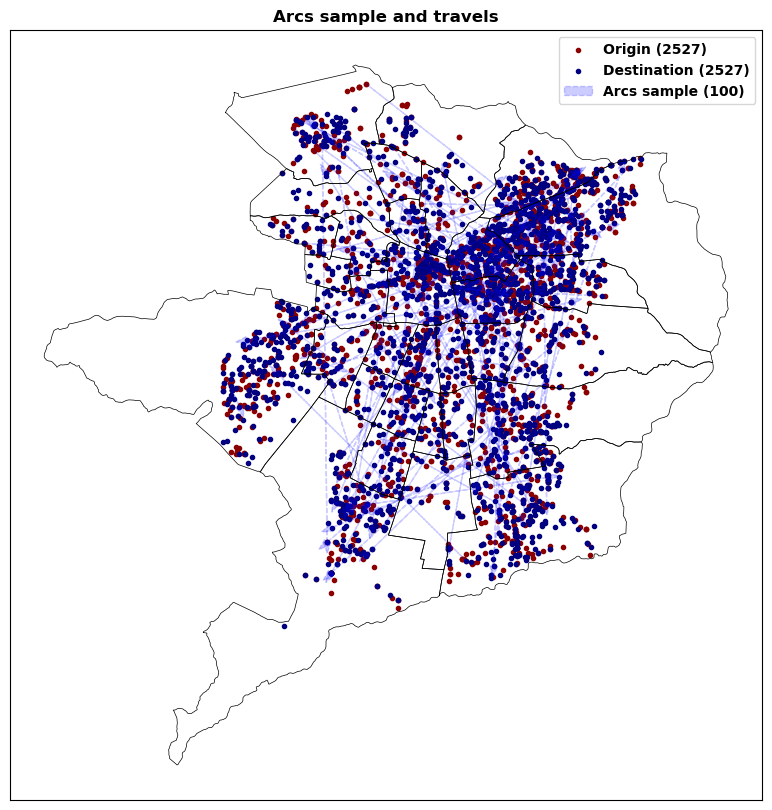

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color="black", linewidth=.5)
demand.iloc[idxs].plot(ax=ax, marker='.', color='darkred', label=f'Origin ({len(idxs)})')
demand.iloc[idxs + int(len(demand)/2)].plot(ax=ax, marker='.', color='navy', label=f'Destination ({len(idxs)})')

for eidx, erow in edges_sample.sample(100).reset_index().iterrows():
    ax.arrow(
        erow.Origin.x,
        erow.Origin.y,
        erow.Dest.x - erow.Origin.x,
        erow.Dest.y - erow.Origin.y,
        head_width=500,
        linestyle='--',
        color='blue',
        alpha=.2,
        label=(f'Arcs sample (100)' if eidx==0 else None)
    )

ax.legend()
ax.set_title('Arcs sample and travels')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

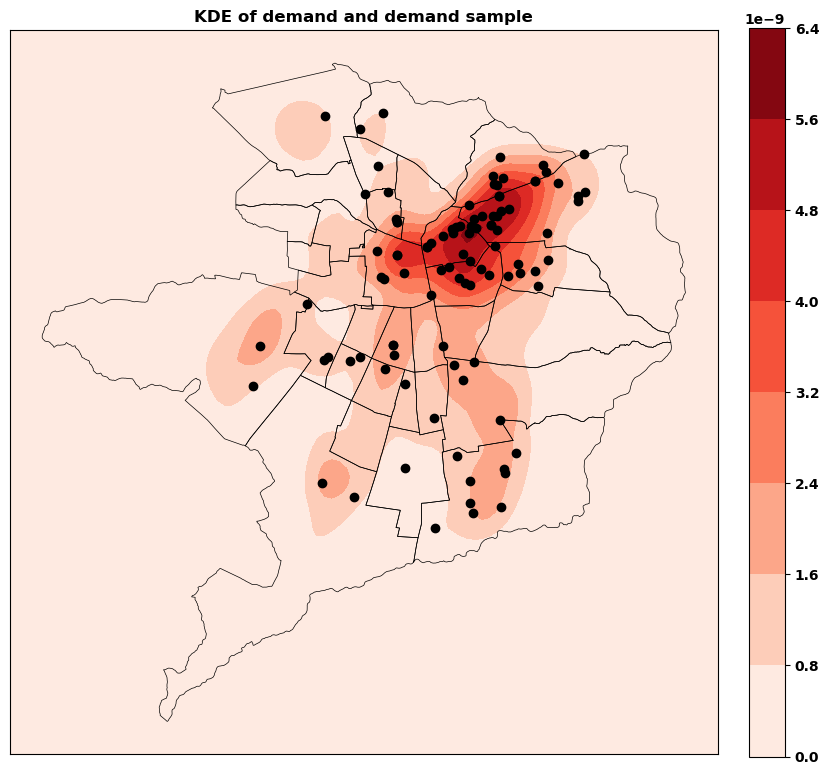

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
sample_nodes = nodes.sample(100)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
X1_, X2_ = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
im = ax.contourf(np.linspace(xmin, xmax, 100),
                   np.linspace(ymin, ymax, 100),
                   kde.evaluate(np.vstack((X1_.ravel(), X2_.ravel()))).reshape(100, 100), cmap='Reds')
ax.scatter([n.x for n in sample_nodes.Node], [n.y for n in sample_nodes.Node], color='black')
fig.colorbar(im, ax=ax, fraction=.047, pad=0.04)
ax.set_title('KDE of demand and demand sample')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

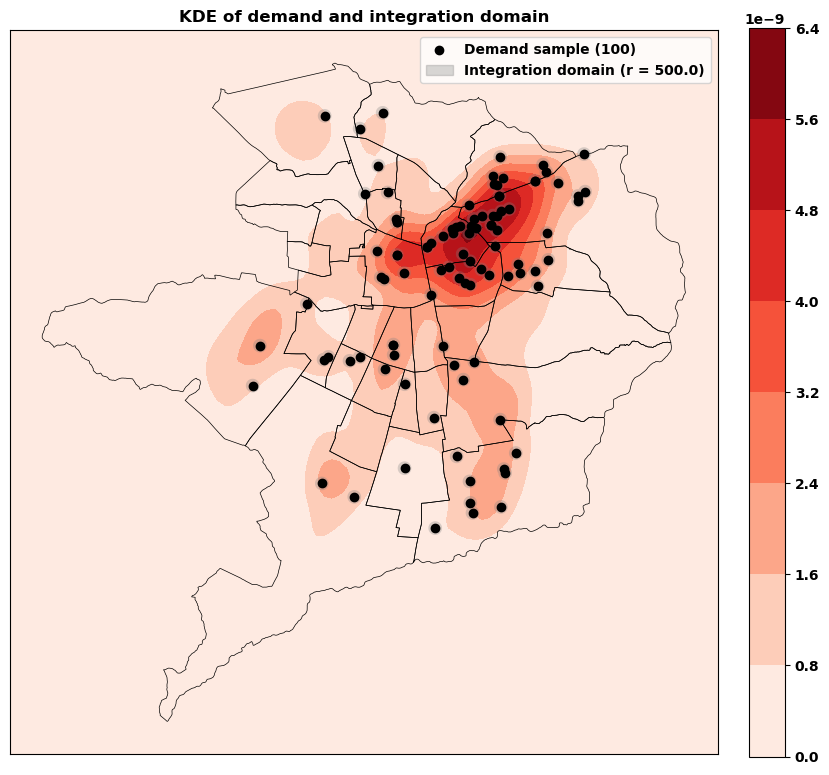

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
X1_, X2_ = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
im = ax.contourf(np.linspace(xmin, xmax, 100),
                   np.linspace(ymin, ymax, 100),
                   kde.evaluate(np.vstack((X1_.ravel(), X2_.ravel()))).reshape(100, 100),
                   cmap='Reds')
fig.colorbar(im, ax=ax, fraction=.047, pad=0.04)
radius = gpd.GeoDataFrame(sample_nodes, geometry='Node').buffer(r)
integration_bound = gpd.GeoSeries(unary_union(radius)).plot(ax=ax, color='gray', alpha=0.3)
patch = mpatches.Patch(color='gray', alpha=0.3, label=f'Integration domain (r = {r})')
ax.scatter([n.x for n in sample_nodes.Node], [n.y for n in sample_nodes.Node], color='black', label=f'Demand sample ({len(sample_nodes)})')
handles, labels = ax.get_legend_handles_labels()
handles.append(patch)
ax.legend(handles=handles)
ax.set_title('KDE of demand and integration domain')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

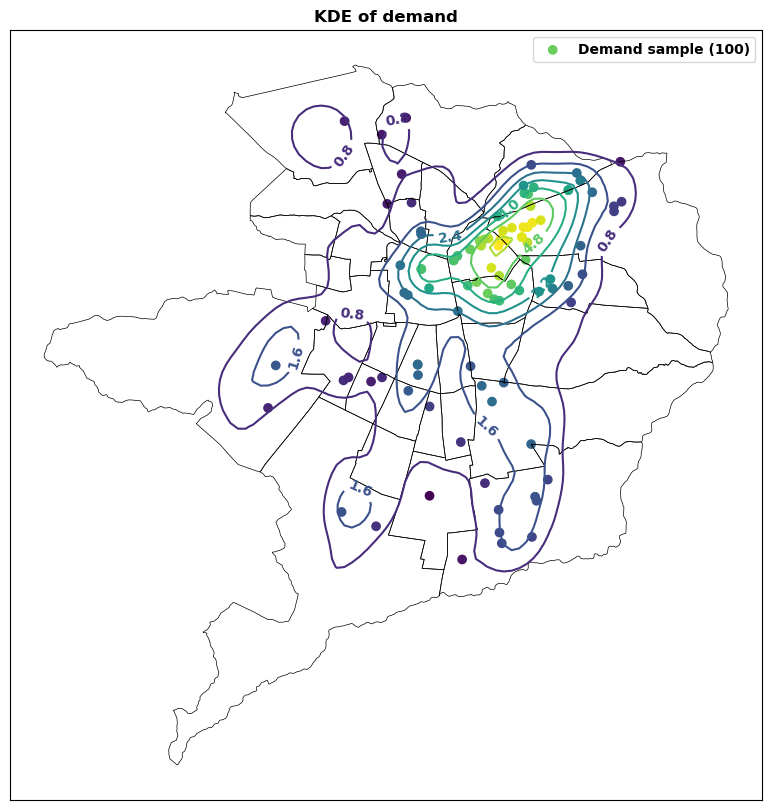

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
X1_, X2_ = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
im = ax.contour(np.linspace(xmin, xmax, 100),
                   np.linspace(ymin, ymax, 100),
                   kde.evaluate(np.vstack((X1_.ravel(), X2_.ravel()))).reshape(100, 100))
ax.clabel(im, inline=True, fontsize=10)
ax.scatter([n.x for n in sample_nodes.Node],
           [n.y for n in sample_nodes.Node],
           c=sample_nodes.f,
           label=f'Demand sample ({len(sample_nodes)})')
ax.legend()
ax.set_title('KDE of demand')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

In [ ]:
p = D.iloc[1]
sols = feasible_paths(p, (1 + p.tol) * manhattan(p.O, p.D), verb=1)
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
area = reachable_area(p)
area.boundary.plot(ax=ax, color='black', linestyle='--', label=f'Reachable area (tolerance of {p.tol}%)')

routes_sample = sols.sample(min(10, len(sols)))
color_values = (routes_sample.total_w - routes_sample.total_w.min()) * (routes_sample.total_w - routes_sample.total_w.min()).max() ** -1
pp_color_values = (routes_sample.total_w - routes_sample.total_w.min())/ routes_sample.total_w * 100
colors = plt.cm.Reds(color_values)
for k, (_, s) in enumerate(routes_sample.iterrows()):
    xs = [p.x for p in s.path]
    ys = [p.y for p in s.path]
    line = ax.plot(xs, ys, linestyle='-', color=colors[k], alpha=0.8, label='Feasible paths sample' if k == 0 else None)

nodes.plot(ax=ax, edgecolor='darkred', facecolor='none', label=f'Nodes outside the reachable area ({len(nodes) - len(reachable_nodes(area)) - 2})')
reachable_nodes(area).plot(ax=ax, marker='o', color='darkred', label=f'Nodes in the reachable area ({len(reachable_nodes(area))})')
ax.scatter([p.O.x, p.D.x], [p.O.y, p.D.y], color='black', marker='*', s=1e2, label='Origin/Destination')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=pp_color_values.min(), vmax=pp_color_values.max()))
cbar = fig.colorbar(sm, ax=ax, fraction=.047, pad=0.04)
cbar.set_label(r'Extra travel (%)')
ax.legend()
ax.set_title('Feasible paths node n°8')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

$$
R_j = \{n_i: \lVert min_{\lambda} (O_j + \lambda (D_j - O_j) - n_i) \rVert_1 \leq \frac{1}{2}\lVert O_j - D_j \rVert_1 \cdot (1 + tol)\}
$$

Iter 0, nsols: 0, unfinished_paths: 1
Iter 1, nsols: 2, unfinished_paths: 12
Iter 2, nsols: 22, unfinished_paths: 120
Iter 3, nsols: 120, unfinished_paths: 828


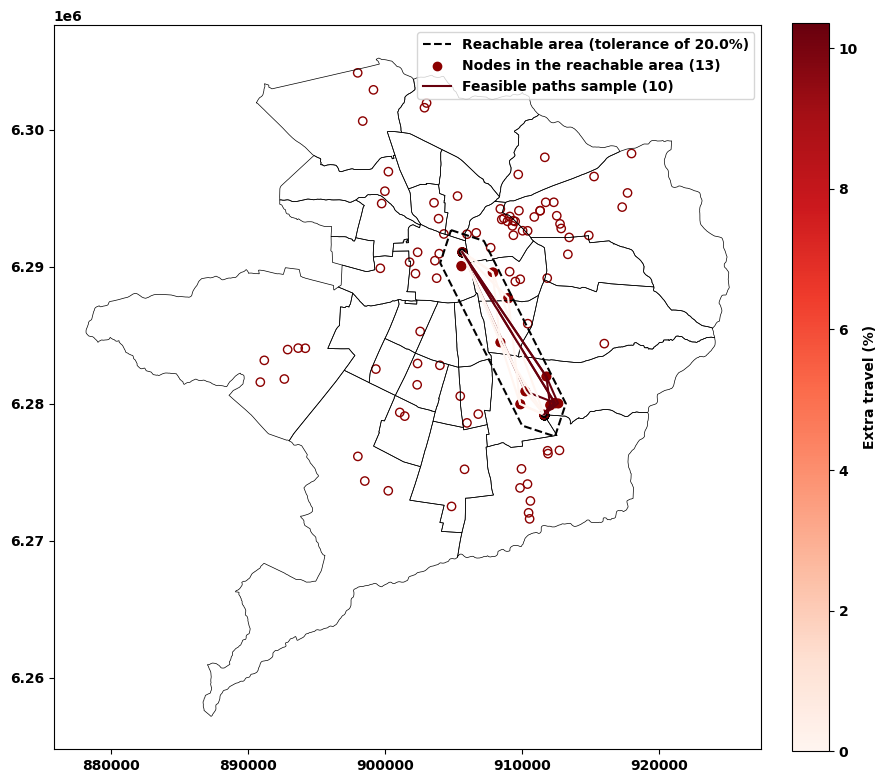

In [ ]:
demandnode_ = DemandNode(O=p.O, D=p.D, tol=p.tol, f=p.f)
demandnode_.get_paths(verb=1)
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
area = demandnode_.reachable_area()
area.boundary.plot(ax=ax, color='black', linestyle='--', label=f'Reachable area (tolerance of {demandnode_.tol * 100}%)')
demandnode_.reachable_nodes().plot(ax=ax, marker='o', color='darkred', label=f'Nodes in the reachable area ({len(demandnode_.reachable_nodes())})')
demandnode_.plot_paths(fig=fig, sample_size=10, label='Feasible paths sample')
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax)
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

## Max coverage (manhattan dist.) w/ budget constraints

$$
\begin{align*}
\max & f_j \cdot y_j &\\
s.t.\, & y_j \leq \sum_{i\in R_j} x_i &\forall j \in J\\
&\sum_{i \in I} x_i \leq N_{CE}
\end{align*}    
$$

In [98]:
demand_ = Demand(D.apply(lambda x: DemandNode(O=x.O, D=x.D, f=x.f, tol=x.tol), axis=1).to_numpy())

I = 2 * len(demand_)
J = len(demand_)
Nce = 165

m = gp.Model()

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels

# Set objective function
obj = gp.quicksum([demand_[j].f * y[j] for j in range(J)])
m.setObjective(obj, gp.GRB.MAXIMIZE)

# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([x[i] for i in demand_[j].reachable_nodes().index]) >= y[j])

m.addConstr(gp.quicksum([x[i] for i in range(I)]) <= Nce)

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-14
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2528 rows, 7581 columns and 489230 nonzeros
Model fingerprint: 0xca2575d0
Variable types: 0 continuous, 7581 integer (7581 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 2e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 422 rows and 2841 columns
Presolve time: 1.55s
Presolved: 2106 rows, 4740 columns, 232386 nonzeros
Variable types: 0 continuous, 4740 integer (4740 binary)
Found heuristic solution: objective 3.7540426

Root relaxation: objective 4.547927e+00, 1301 iterations, 0.06 seconds (0.17 work units)

    Nodes    |    C

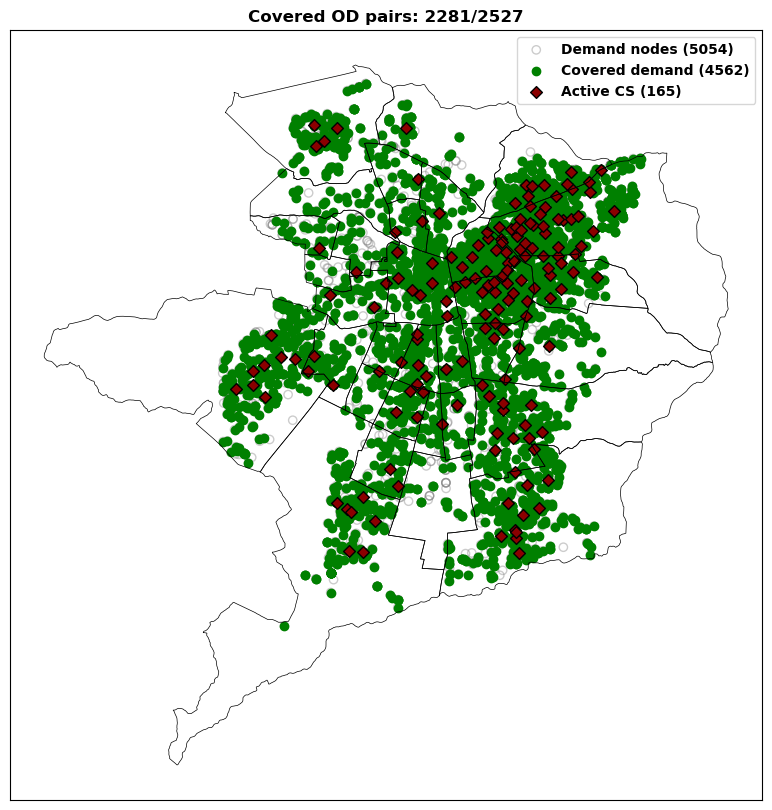

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.4, ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')

ax.set_title(f'Covered OD pairs: {int(y.X.sum())}/{len(y.X)}')
#sample_idxs = np.random.choice(np.arange(0, len(demand_)), 100, replace=False)
#for i, d in enumerate(demand_):
#    if y.X[i] == 1 and (i in sample_idxs):
#        active_mask = x.X.astype(bool)
#        reachable_mask = np.zeros(len(nodes), dtype=bool)
#        reachable_mask[d.reachable_nodes().index] = True
#        matches = nodes[reachable_mask & active_mask].reset_index().Node
#        match_distances = np.array([manhattan(d.O, m) + manhattan(d.D, m) for m in matches])
#        closest_match = matches[np.argmin(match_distances)]
#        ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
#        ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')

nodes[x.X.astype(bool)].plot(edgecolor='black', facecolor='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')

ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

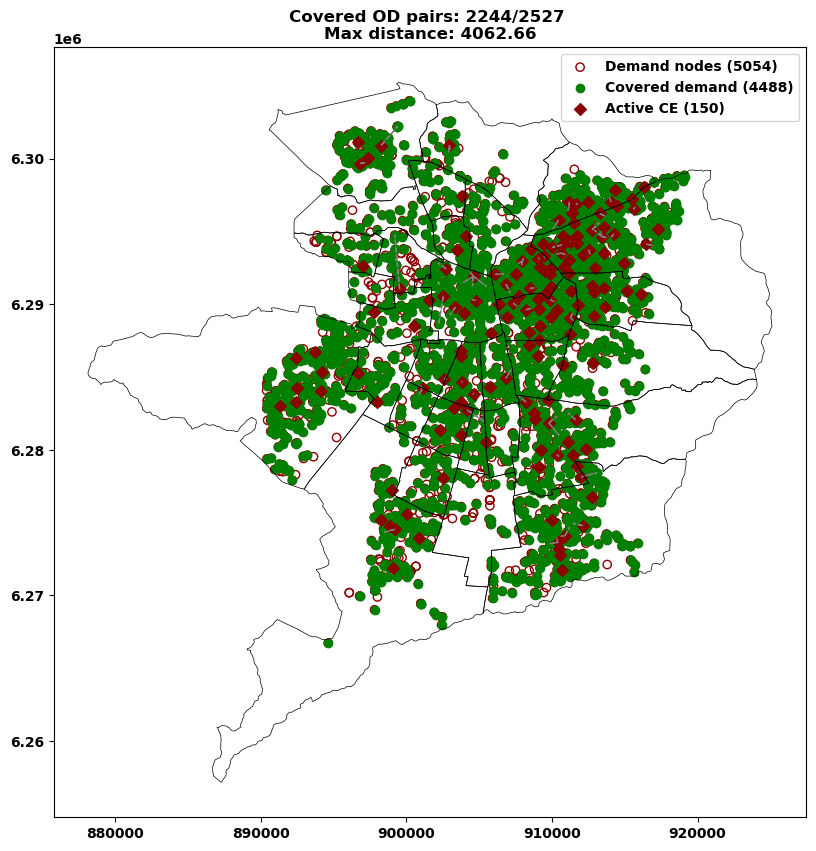

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.4, ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')

min_distances = []
for i, d in enumerate(demand_):
    if y.X[i] == 1 and (i in sample_idxs):
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances_O = np.array([manhattan(d.O, m) for m in matches])
        match_distances_D = np.array([manhattan(d.D, m) for m in matches])
        if match_distances_O.min() < match_distances_D.min():
            closest_match = matches[np.argmin(match_distances_O)]
            ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        else:
            closest_match = matches[np.argmin(match_distances_D)]
            ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
        min_distances.append(min(manhattan(d.O, closest_match), manhattan(d.D, closest_match)))
        
ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))

nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

## Max coverage (manhattan dist) w/o budget constraint

$$
\begin{align*}
\min & \sum_{i\in I} x_i &\\
s.t.\, & y_j \leq \sum_{i\in R_j} x_i &\forall j \in J\\
&\sum_{j \in J} y_j = |J|
\end{align*}    
$$

In [14]:
m = gp.Model()

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels

# Set objective function
obj = gp.quicksum([x[i] for i in range(I)])
m.setObjective(obj, gp.GRB.MINIMIZE)

# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([x[i] for i in demand_[j].reachable_nodes().index]) >= y[j])

m.addConstr(gp.quicksum([y[j] for j in range(J)]) == J)

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2528 rows, 7581 columns and 486703 nonzeros
Model fingerprint: 0xafdd3fa5
Variable types: 0 continuous, 7581 integer (7581 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 3e+03]
Found heuristic solution: objective 400.0000000
Presolve removed 2390 rows and 7399 columns
Presolve time: 0.31s
Presolved: 138 rows, 182 columns, 636 nonzeros
Found heuristic solution: objective 339.0000000
Variable types: 0 continuous, 182 integer (182 binary)

Root relaxation: objective 3.294524e+02, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

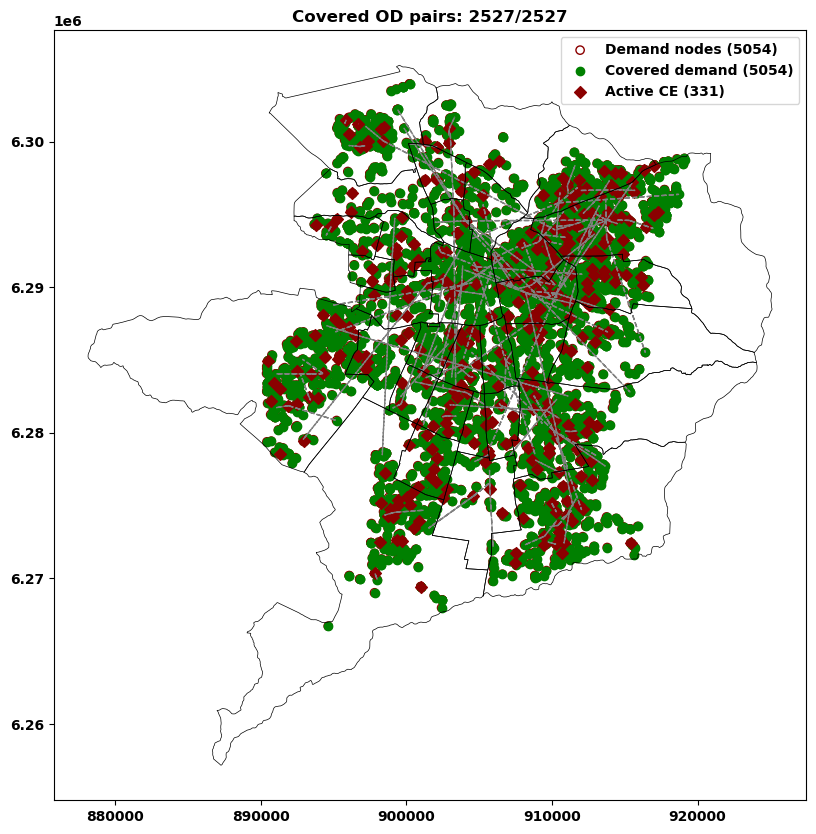

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')
ax.set_title(f'Covered OD pairs: {int(y.X.sum())}/{len(y.X)}')
for i, d in enumerate(demand_):
    if y.X[i] == 1 and (i in sample_idxs):
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances = np.array([manhattan(d.O, m) + manhattan(d.D, m) for m in matches])
        closest_match = matches[np.argmin(match_distances)]
        ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
ax.legend();

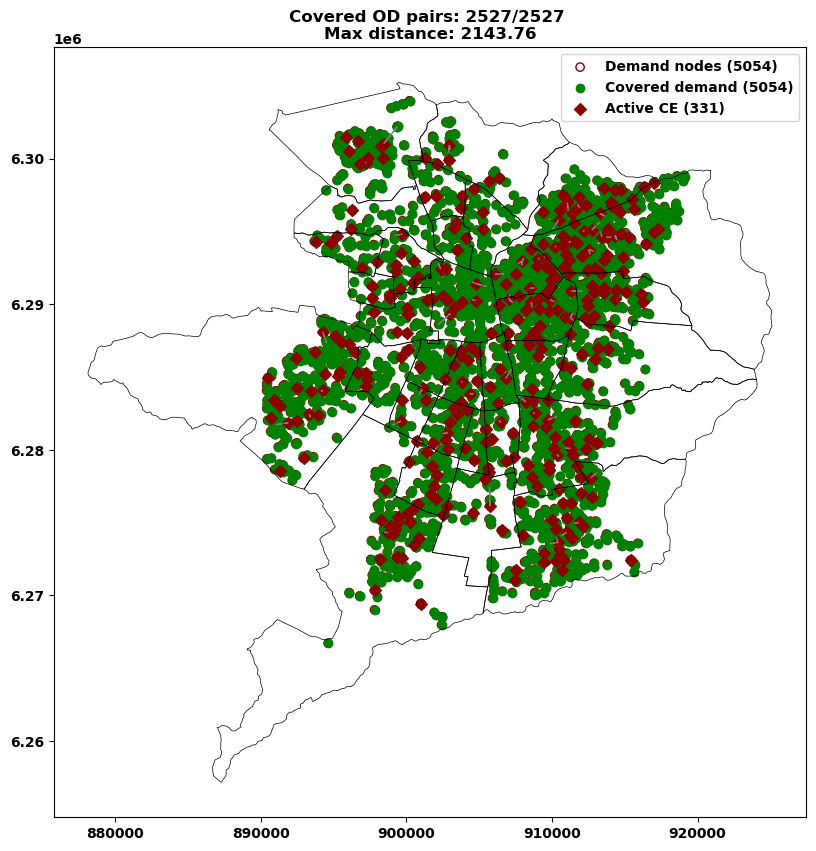

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')

min_distances = []
for i, d in enumerate(demand_):
    if y.X[i] == 1 and (i in sample_idxs):
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances_O = np.array([manhattan(d.O, m) for m in matches])
        match_distances_D = np.array([manhattan(d.D, m) for m in matches])
        if match_distances_O.min() < match_distances_D.min():
            closest_match = matches[np.argmin(match_distances_O)]
            ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        else:
            closest_match = matches[np.argmin(match_distances_D)]
            ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
        min_distances.append(min(manhattan(d.O, closest_match), manhattan(d.D, closest_match)))
ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
ax.legend();

## Min distance w/o budget constraints

In [ ]:
dists = {(i, j): manhattan(nodes.iloc[i].Node, nodes.iloc[j].Node)\
    for i in range(len(nodes))\
        for j in range(len(nodes))}

M = 1e10

m = gp.Model()

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
d = m.addVar(vtype=gp.GRB.CONTINUOUS, name='d')
dists_var = m.addMVar(shape=(I, J), vtype=gp.GRB.CONTINUOUS, name="dists_var")
dist_assignation = m.addMVar(shape=J, vtype=gp.GRB.CONTINUOUS, name="dist_assignation")

# Set objective function
m.setObjective(d, gp.GRB.MINIMIZE)

# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([x[i] for i in demand_[j].reachable_nodes().index]) >= y[j])

m.addConstr(gp.quicksum([y[j] for j in range(J)]) == J)

for i in range(I):
    for j in range(J):
        m.addConstr(dists_var[i, j] == dists[i, j] + (1 - x[i]) * M)

for j in range(J):
    m.addConstr(dist_assignation[j] == gp.min_([dists_var[i, j] for i in demand_[j].reachable_nodes().index]))
    m.addConstr(d >= dist_assignation[j])


m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5101 rows, 5201 columns and 10530 nonzeros
Model fingerprint: 0x43d82036
Model has 50 general constraints
Variable types: 5051 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 4740 rows and 4654 columns
Presolve time: 0.02s
Presolved: 361 rows, 547 columns, 1105 nonzeros
Presolved model has 224 SOS constraint(s)
Variable types: 252 continuous, 295 integer (290 binary)

Root relaxation: objective 0.000000e+00, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current

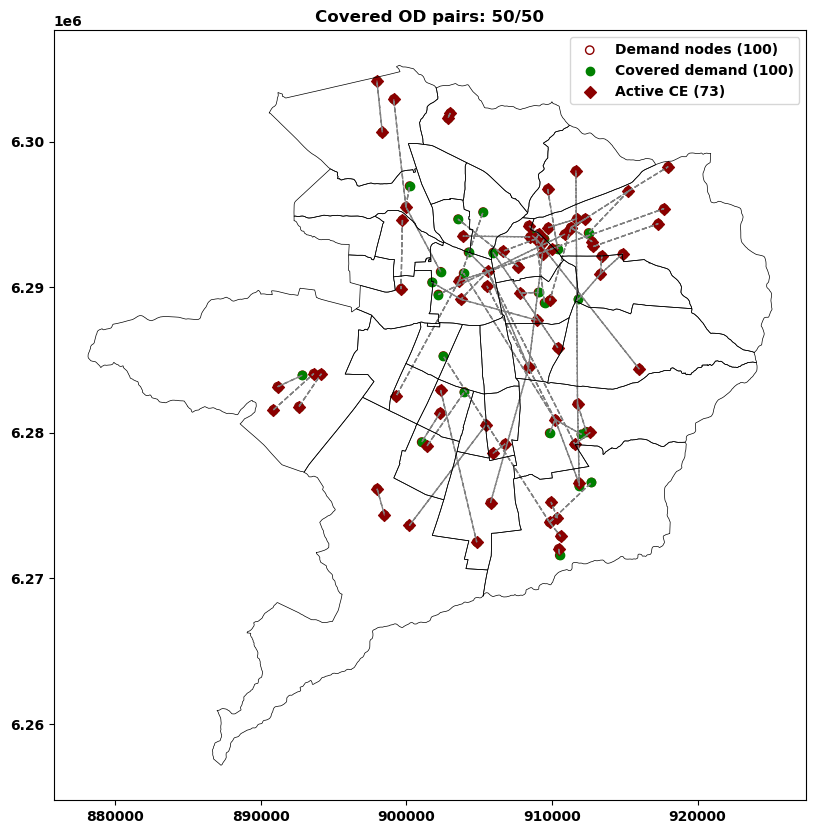

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')
ax.set_title(f'Covered OD pairs: {int(y.X.sum())}/{len(y.X)}')
for i, d in enumerate(demand_):
    if y.X[i] == 1:
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances = np.array([manhattan(d.O, m) + manhattan(d.D, m) for m in matches])
        closest_match = matches[np.argmin(match_distances)]
        ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
ax.legend();

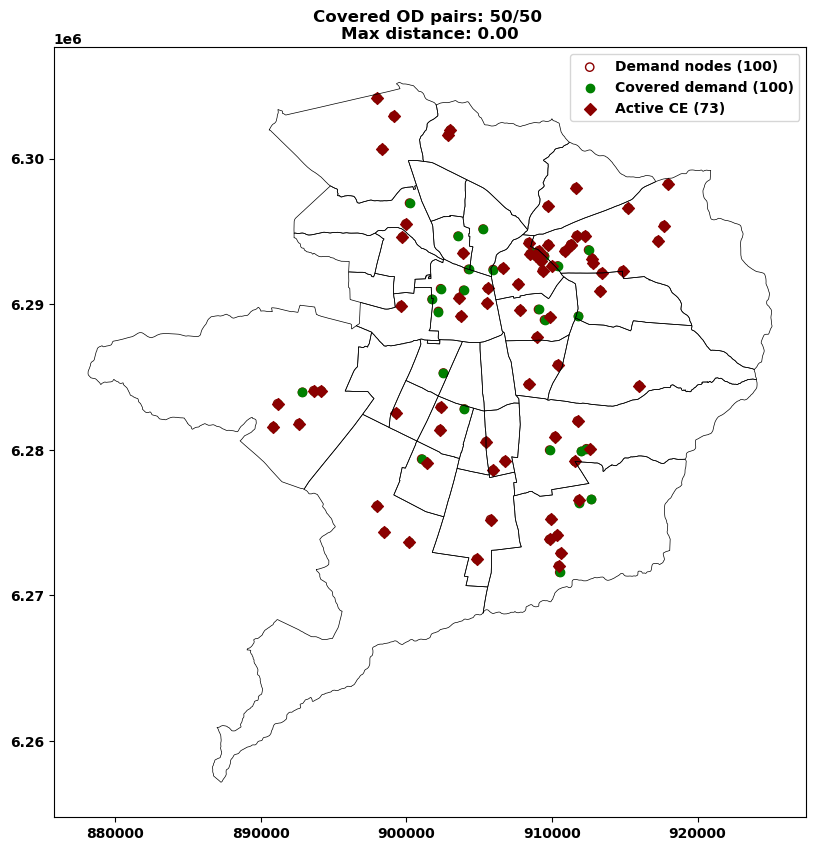

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')

min_distances = []
for i, d in enumerate(demand_):
    if y.X[i] == 1:
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances_O = np.array([manhattan(d.O, m) for m in matches])
        match_distances_D = np.array([manhattan(d.D, m) for m in matches])
        if match_distances_O.min() < match_distances_D.min():
            closest_match = matches[np.argmin(match_distances_O)]
            ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        else:
            closest_match = matches[np.argmin(match_distances_D)]
            ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
        min_distances.append(min(manhattan(d.O, closest_match), manhattan(d.D, closest_match)))
ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
ax.legend();

## Max coverage w/ capacity and budget constraints

n_long, n_lat = 20, 20

xbins = np.linspace(min(nodes.Node.x), max(nodes.Node.x), n_long)
ybins = np.linspace(min(nodes.Node.y), max(nodes.Node.y), n_lat)

def get_square(coordx, coordy, xbins=xbins, ybins=ybins):
    hx = xbins[1] - xbins[0]
    hy = ybins[1] - ybins[0]
    return int((coordx - xbins[0])/hx), int((coordy - ybins[1])/hy)

nodes['Disc'] = nodes.apply(lambda n: get_square(n.Node.x, n.Node.y, axis=1))

COrigin = np.zeros((len(xbins), len(ybins), 2))
CDest = np.zeros((len(xbins), len(ybins), 2))
for i in range(len(xbins)):
    for j in range(len(ybins)):
        origen_ij = nodes[:J][nodes[:J]['Disc'] == (i, j)]
        destino_ij = nodes[J:].reset_index().iloc(origen_ij.index)
        COrigin[i, j] = [origen_ij.Node.x.mean(), origen_ij.Node.y.mean()]
        CDest[i, j] = [destino_ij.Node.x.mean(), destino_ij.Node.y.mean()]

$$
\begin{align*}
\max & \sum_{j\in J} f_j \cdot y_j &&\\
s.t.\, & \sum_{i\in R_j} z_{i,j} \geq y_j & \forall j \in J & \quad\text{(Assigning a trip to an EC satisfies its demand)}\\
&\sum_{j \in J} z_{i,j} \leq K_i & \forall i \in I & \quad\text{(Capacity of the CEs)}\\
& \sum_{j \in J} z_{i,j} \leq x_i \cdot J & \forall i \in I & \quad\text{(A CE is active if have at least one associated trip)}\\
& \sum_{i \in I} x_i \leq N_{CE} && \quad\text{(Maximum number of Active CS)}
\end{align*}
$$

In [22]:
m = gp.Model()

#dists = {(i, j): min([manhattan(nodes.iloc[k], nodes.iloc[j]) for k in demand_[j].reachable_nodes().index]) for i in range(I) for j in range(J)}
K = 2 * 24 * np.ones(I)
Nce = 165

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z = m.addMVar(shape=(I, J), vtype=gp.GRB.BINARY, name='z') # Assignations

In [25]:
# Set objective function
obj = gp.quicksum([demand_[j].f * y[j] for j in range(J)])
m.setObjective(obj, gp.GRB.MAXIMIZE)

In [26]:
# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([z[i, j] for i in demand_[j].reachable_nodes().index]) >= y[j])

for i in range(I):
    m.addConstr(gp.quicksum([z[i, j] for j in range(J)]) <= K[i])
    m.addConstr(x[i] * J >= gp.quicksum([z[i, j] for j in range(J)]))

m.addConstr(gp.quicksum([x[i] for i in range(I)]) <= Nce)
#m.addConstr(gp.quicksum([z[i, j] for j in range(J)]))

<MConstr () *awaiting model update*>

In [27]:
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12636 rows, 12779039 columns and 26037200 nonzeros
Model fingerprint: 0xa0272f65
Variable types: 0 continuous, 12779039 integer (12779039 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-04, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 2 rows and 12289809 columns (presolve time = 5s) ...
Presolve removed 3 rows and 12289810 columns (presolve time = 10s) ...
Presolve removed 5055 rows and 12289810 columns (presolve time = 15s) ...
Presolve removed 5055 rows and 12289810 columns (presolve time = 22s) ...
Presolve removed 5055 rows and 12289810 columns
Presolve time: 24.56s
Presolved: 7581 rows, 489229 columns, 975931 n

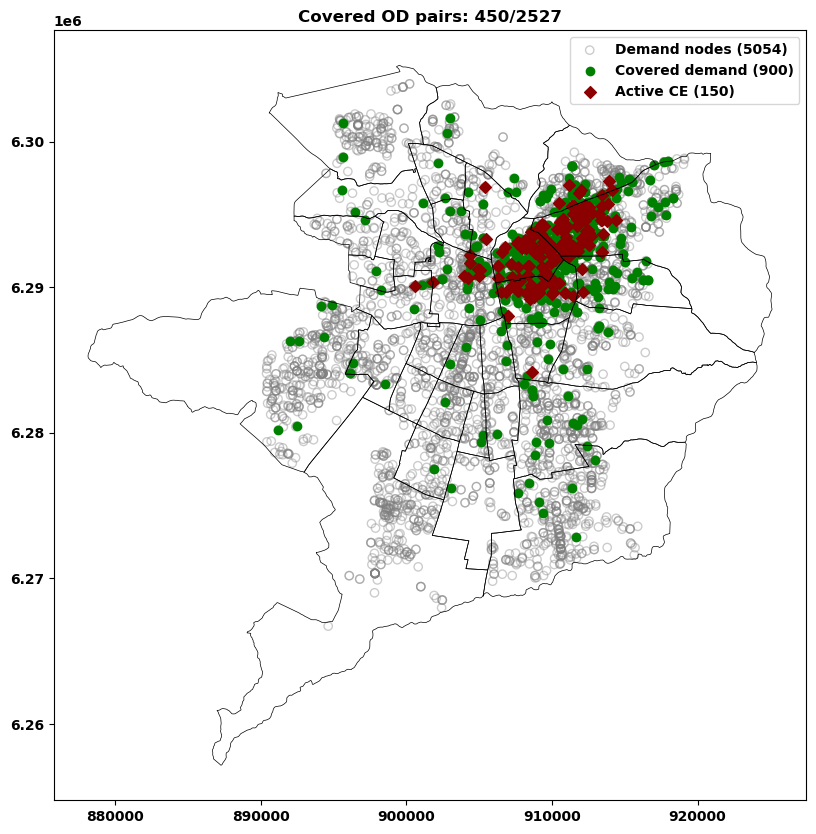

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})', alpha=.4)
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=0) > 0]], [d.O.y for d in demand_[z.X.sum(axis=0) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=0) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=0) > 0]], [d.D.y for d in demand_[z.X.sum(axis=0) > 0]], color='green')
nodes[z.X.sum(axis=1) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=1) > 0).sum()})')

ax.set_title(f'Covered OD pairs: {(z.X.sum(axis=0) > 0).sum()}/{z.X.shape[1]}')

#k = 0
#plot_idxs = np.random.randint(0, z.X.sum(axis=(0, 1)), 100)
#for i in range(I):
#    for j in range(J):
#        if (z.X[i, j] > 0) and k in plot_idxs:
#            d = demand_[j]
#            ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
#            ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
#            k += 1
        
ax.legend();

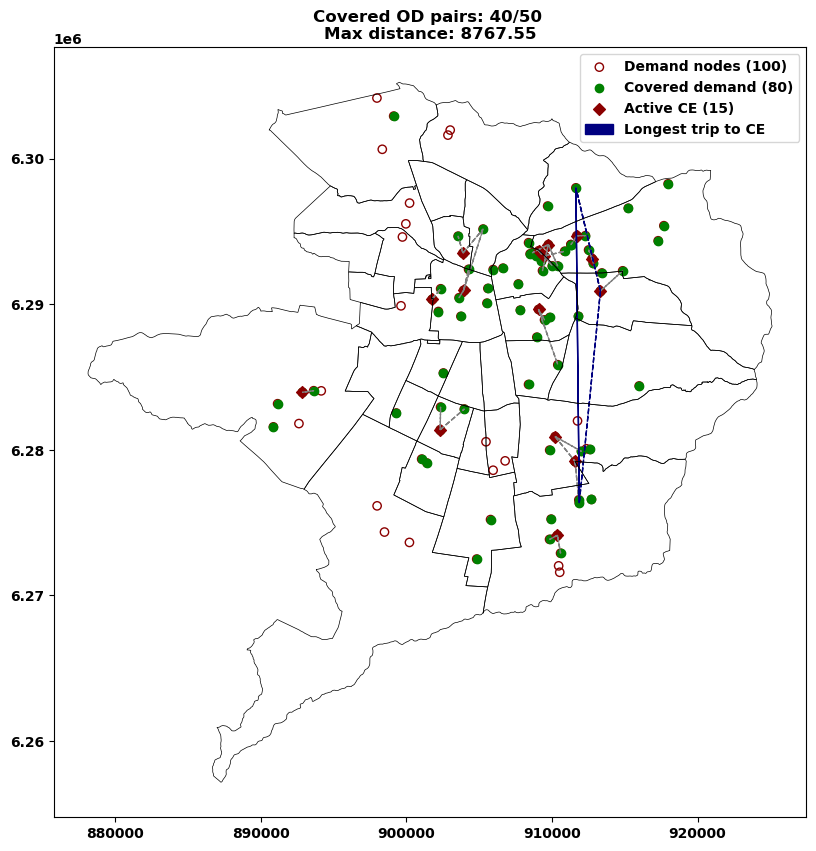

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=0) > 0]], [d.O.y for d in demand_[z.X.sum(axis=0) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=0) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=0) > 0]], [d.D.y for d in demand_[z.X.sum(axis=0) > 0]], color='green')
nodes[z.X.sum(axis=1) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=1) > 0).sum()})')


min_distances = []
for i in range(I):
    for j in range(J):
        if z.X[i, j] > 0:
            d = demand_[j]
            if manhattan(d.O, nodes.iloc[i].Node) < manhattan(d.D, nodes.iloc[i].Node):
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
            else:
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
            min_distances.append(min(manhattan(d.O, nodes.iloc[i].Node), manhattan(d.D, nodes.iloc[i].Node)))

for i in range(I):
    for j in range(J):
        if z.X[i, j] > 0:
            d = demand_[j]
            if min(manhattan(demand_[j].O, nodes.iloc[i].Node), manhattan(demand_[j].D, nodes.iloc[i].Node)) == max(min_distances):
                ax.arrow(d.O.x, d.O.y, d.D.x  - d.O.x, d.D.y - d.O.y, linestyle='-', color='navy', label='Longest trip to CE')
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='navy')
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='navy')

ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
        
ax.legend();

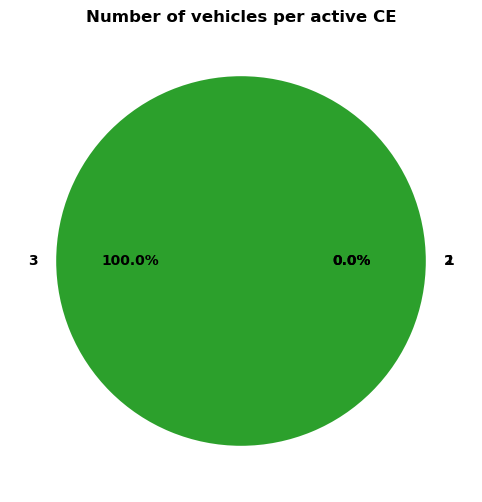

In [34]:
n_vehic = z.X.sum(axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

## Max coverage with capacity constraint w/o budget constraints

$$
\begin{align*}
\min & \sum_{i\in I} x_i &\\
s.t.\, & \sum_{i\in R_j} z_{i,j} \geq y_j & \forall j \in J \\
&\sum_{j \in J} z_{i,j} \leq K_i & \forall i \in I \\
& \sum_{j \in J} z_{i,j} \leq x_i \cdot J & \forall i \in I\\
& \sum_{j \in J} y_j = |J|
\end{align*}    
$$

In [ ]:
m = gp.Model()

K = 3 * np.ones(I)

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z = m.addMVar(shape=(I, J), vtype=gp.GRB.BINARY, name='z') # Assignations

# Set objective function
obj = gp.quicksum([x[i] for i in range(I)])
m.setObjective(obj, gp.GRB.MINIMIZE)

# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([z[i, j] for i in demand_[j].reachable_nodes().index]) >= y[j])

for i in range(I):
    m.addConstr(gp.quicksum([z[i, j] for j in range(J)]) <= K[i])
    m.addConstr(x[i] * J >= gp.quicksum([z[i, j] for j in range(J)]))

m.addConstr(gp.quicksum([y[j] for j in range(J)]) == J)

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 251 rows, 5150 columns and 10530 nonzeros
Model fingerprint: 0xaf5ea546
Variable types: 0 continuous, 5150 integer (5150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 5e+01]
Found heuristic solution: objective 43.0000000
Presolve removed 198 rows and 4960 columns
Presolve time: 0.01s
Presolved: 53 rows, 190 columns, 361 nonzeros
Found heuristic solution: objective 30.0000000
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 2.233333e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

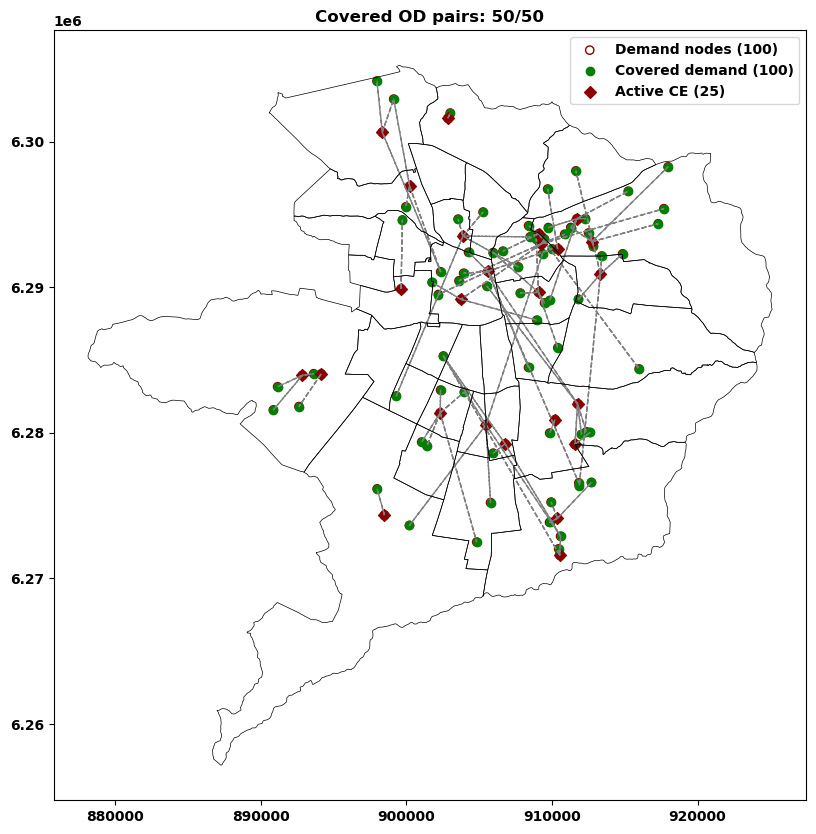

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=0) > 0]], [d.O.y for d in demand_[z.X.sum(axis=0) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=0) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=0) > 0]], [d.D.y for d in demand_[z.X.sum(axis=0) > 0]], color='green')
nodes[z.X.sum(axis=1) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=1) > 0).sum()})')

ax.set_title(f'Covered OD pairs: {(z.X.sum(axis=0) > 0).sum()}/{z.X.shape[1]}')

for i in range(I):
    for j in range(J):
        if z.X[i, j] > 0:
            d = demand_[j]
            ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
            ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
        
ax.legend();

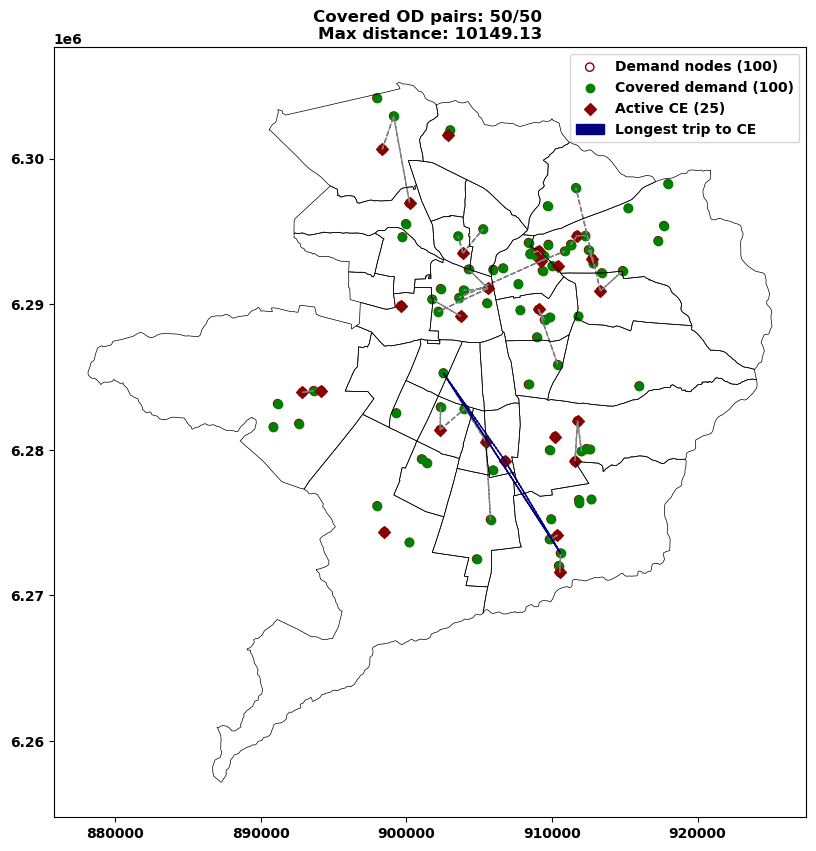

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=0) > 0]], [d.O.y for d in demand_[z.X.sum(axis=0) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=0) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=0) > 0]], [d.D.y for d in demand_[z.X.sum(axis=0) > 0]], color='green')
nodes[z.X.sum(axis=1) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=1) > 0).sum()})')


min_distances = []
for i in range(I):
    for j in range(J):
        if z.X[i, j] > 0:
            d = demand_[j]
            if manhattan(d.O, nodes.iloc[i].Node) < manhattan(d.D, nodes.iloc[i].Node):
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
            else:
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
            min_distances.append(min(manhattan(d.O, nodes.iloc[i].Node), manhattan(d.D, nodes.iloc[i].Node)))

for i in range(I):
    for j in range(J):
        if z.X[i, j] > 0:
            d = demand_[j]
            if min(manhattan(demand_[j].O, nodes.iloc[i].Node), manhattan(demand_[j].D, nodes.iloc[i].Node)) == max(min_distances):
                ax.arrow(d.O.x, d.O.y, d.D.x  - d.O.x, d.D.y - d.O.y, linestyle='-', color='navy', label='Longest trip to CE')
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='navy')
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='navy')

ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
        
ax.legend();

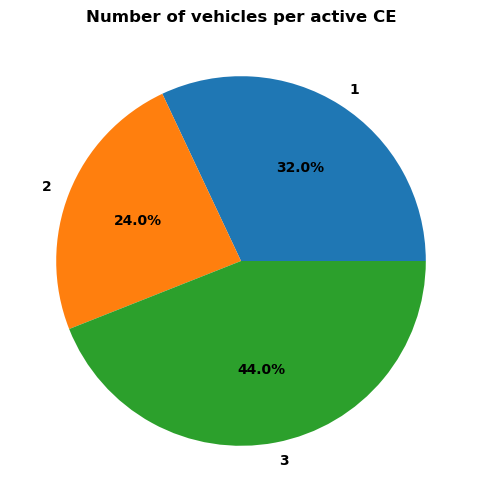

In [ ]:
n_vehic = z.X.sum(axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

## Max coverage with capacity, budget and time constraints

$$
\begin{align*}
\max & \sum_{j\in J} f_j \cdot y_j &&\\
s.t.\, & \sum_{i\in R_j, \,t \in T} z_{i,j,t} \geq y_j & \forall j \in J & \quad\text{(Assigning a trip to an EC at any time satisfies its demand)}\\
&\sum_{j \in J} z_{i,j,t} \leq K_i & \forall i \in I, \, \forall t \in T & \quad\text{(Capacity of the CEs)}\\
& \sum_{j \in J, \, t \in T} z_{i,j,t} \leq x_i \cdot J & \forall i \in I & \quad\text{(A CE is active if have at least one associated trip at any time)}\\
& \sum_{i \in I} x_i \leq N_{CE} && \quad\text{(Maximum number of Active CSs)}\\
& 0.9 \cdot Tp_t \leq \sum_{i \in I, \, j \in J} z_{i, j, t} \leq 1.1 \cdot Tp_t & \forall t \in T & \quad\text{(Time distribution of trips)}
\end{align*}    
$$

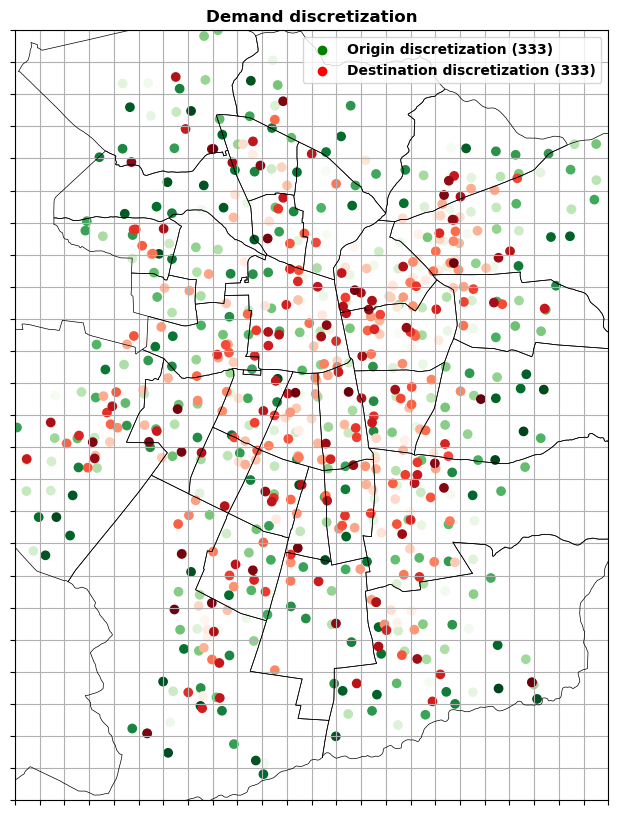

In [97]:
from discretization import D_disc, xbins, ybins

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xbins[0], xbins[-1])
ax.set_ylim(ybins[0], ybins[-1])
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
gpd.GeoSeries(D_disc.O).plot(ax=ax, cmap='Greens', c=D_disc.N)
gpd.GeoSeries(D_disc.D).plot(ax=ax, cmap='Reds', c=D_disc.N)
ax.set_xticks(xbins, labels='')
ax.set_yticks(ybins, labels='')
ax.grid()
ax.scatter([], [], label=f'Origin discretization ({len(D_disc)})', color='green')
ax.scatter([], [], label=f'Destination discretization ({len(D_disc)})', color='red')
ax.legend()
ax.set_title('Demand discretization');

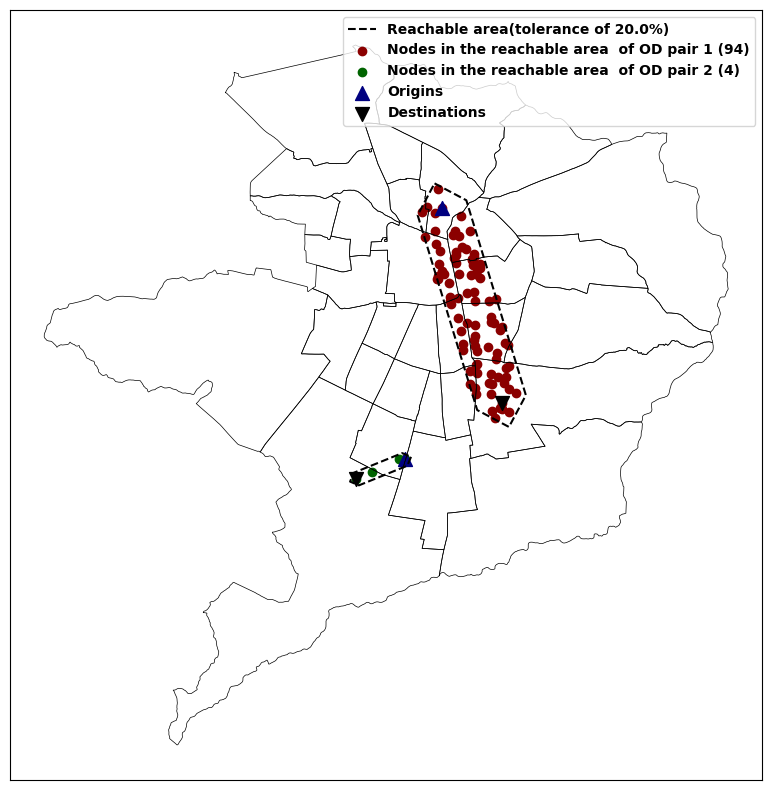

In [25]:
import pandas as pd
demand_disc_ = Demand(D_disc.apply(lambda x: DemandNode(O=x.O, D=x.D, f=x.f_origin + x.f_dest, tol=x.tol), axis=1).to_numpy())
nodes_disc = pd.concat((D_disc.reset_index()[['O', 'f_origin', 'index', 'N']].rename({'O': 'Node', 'f_origin': 'f', 'index': 'Disc'}, axis=1),
                        D_disc.reset_index()[['D', 'f_dest', 'index', 'N']].rename({'D': 'Node', 'f_dest': 'f', 'index': 'Disc'}, axis=1)))
nodes_disc = gpd.GeoDataFrame(nodes_disc.reset_index().drop('index', axis=1), geometry='Node')
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
area1 = demand_disc_[3].reachable_area()
area1.boundary.plot(ax=ax, color='black', linestyle='--', label=f'Reachable area(tolerance of {demand_disc_[3].tol * 100}%)')
demand_disc_[3].reachable_nodes(nodes=nodes_disc).plot(ax=ax, marker='o', color='darkred', label=f'Nodes in the reachable area  of OD pair 1 ({len(demand_disc_[3].reachable_nodes(nodes=nodes_disc))})')
area2 = demand_disc_[0].reachable_area()
area2.boundary.plot(ax=ax, color='black', linestyle='--')
demand_disc_[0].reachable_nodes(nodes=nodes_disc).plot(ax=ax, marker='o', color='darkgreen', label=f'Nodes in the reachable area  of OD pair 2 ({len(demand_disc_[0].reachable_nodes(nodes=nodes_disc))})')
ax.scatter([demand_disc_[3].O.x, demand_disc_[0].O.x], [demand_disc_[3].O.y, demand_disc_[0].O.y], label='Origins', marker='^', color='navy', s=100)
ax.scatter([demand_disc_[3].D.x, demand_disc_[0].D.x], [demand_disc_[3].D.y, demand_disc_[0].D.y], label='Destinations', marker='v', color='black', s=100)
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

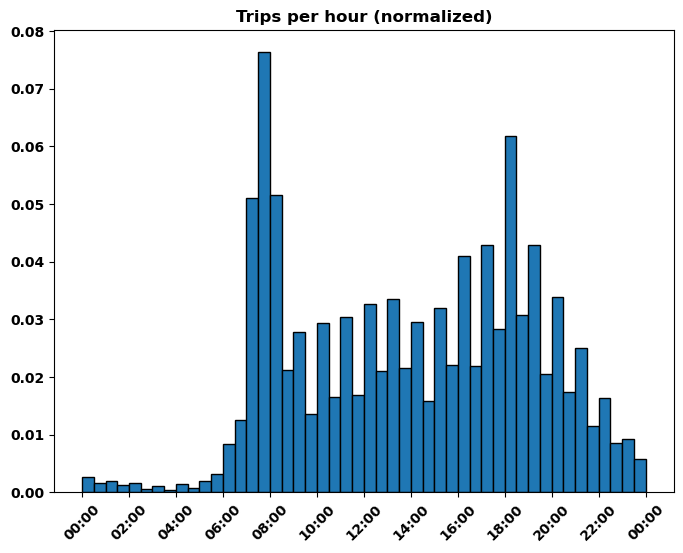

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
arr = Viajes_auto['HoraIni'].astype('datetime64[ns]')
weights = np.ones(len(arr))/len(arr)
hist = ax.hist(arr, bins=48, edgecolor='black', weights=weights)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.set_title('Trips per hour (normalized)')
plt.xticks(rotation = 45);
Tp = hist[0][::2] + hist[0][1::2]

In [109]:
I = 2 * len(demand_disc_)
J = len(demand_disc_)
T = 24
K = 3 * np.ones(I)
Nce = 165

m3 = gp.Model()

# Add variables
x3 = m3.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y3 = m3.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z3 = m3.addMVar(shape=(I, J, T), vtype=gp.GRB.BINARY, name='z') # Assignations

In [110]:
# Set objective function
obj3 = gp.quicksum([demand_disc_[j].f * y3[j] for j in range(J)])
m3.setObjective(obj3, gp.GRB.MAXIMIZE)

In [111]:
# Set constraints
for j in range(J):
    m3.addConstr(gp.quicksum([z3[i, j, t] for i in demand_disc_[j].reachable_nodes(nodes=nodes_disc).index for t in range(T)]) >= y3[j])

for i in range(I):
    for t in range(T):
        m3.addConstr(gp.quicksum([z3[i, j, t] * nodes_disc.iloc[j].N for j in range(J)]) <= 2 * K[i])

for i in range(I):
    m3.addConstr(x3[i] * J >= gp.quicksum([z3[i, j, t] for j in range(J) for t in range(T)]))

m3.addConstr(gp.quicksum([x3[i] for i in range(I)]) <= Nce)

for t in range(T):
    m3.addConstr((Tp).astype(int)[t] * nodes_disc.N.sum() * 0.9 <= gp.quicksum([z3[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))
    m3.addConstr((Tp).astype(int)[t] * nodes_disc.N.sum() * 1.1 >= gp.quicksum([z3[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))

In [121]:
m3.Params.Threads = 8
m3.Params.NodefileStart = .1
m3.optimize()

Set parameter Threads to value 8
Set parameter NodefileStart to value 0.1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Optimize a model with 34525 rows, 21936876 columns and 88298132 nonzeros
Model fingerprint: 0x1518369e
Variable types: 0 continuous, 21936876 integer (21936876 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [4e-04, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 2e+02]
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 0 rows and 11677566 columns (presolve time = 15s) ...
Presolve removed 342 rows and 21507867 columns (presolve time = 26s) ...
Presolve removed 345 rows and 21538401 columns (presolve time = 32s) ...
Presolve removed 4167 rows and 2153

GurobiError: Out of memory

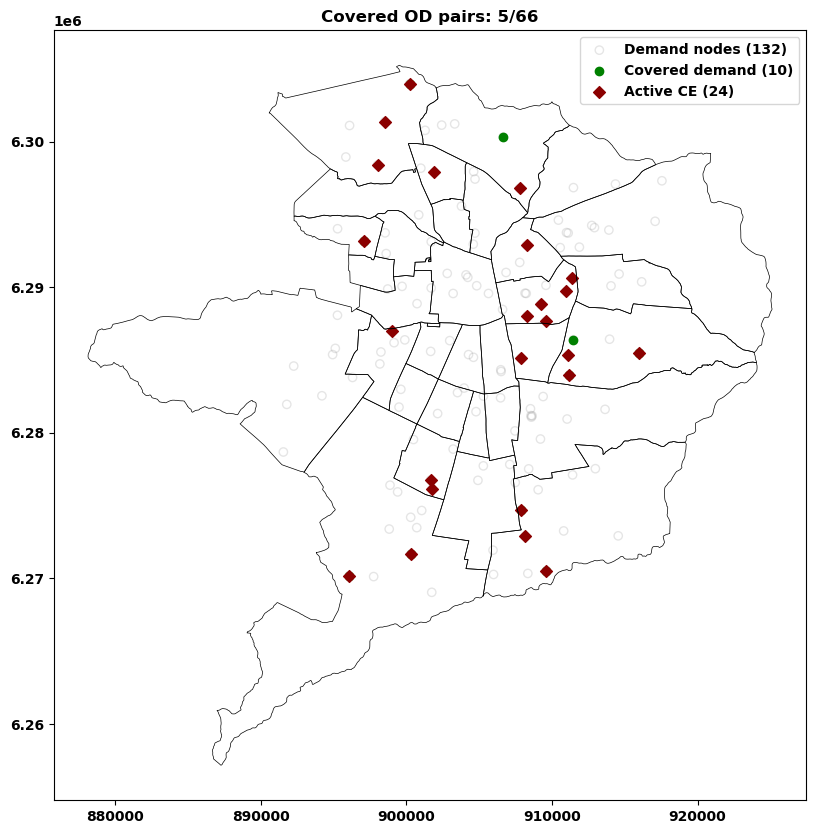

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes_disc.plot(edgecolor='gray', facecolor='none', alpha=.2, ax=ax, label=f'Demand nodes ({len(nodes_disc)})')
ax.scatter([d.O.x for d in demand_disc_[z3.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_disc_[z3.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({2 * (z3.X.sum(axis=(0, 2)) > 0).sum()})')
ax.scatter([d.D.x for d in demand_disc_[z3.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_disc_[z3.X.sum(axis=(0, 2)) > 0]], color='green')

ax.set_title(f'Covered OD pairs: {(z3.X.sum(axis=(0, 2)) > 0).sum()}/{z3.X.shape[1]}')

k = 0
#plot_idxs = np.random.choice(np.arange(0, int(z3.X.sum())), min(100, int(z3.X.sum())), replace=False)
#for i in range(I):
#    for j in range(J):
#        for t in range(T):
#            if (z3.X[i, j, t] > 0) and k in plot_idxs:
#                d = demand_disc_[j]
#                ax.arrow(d.O.x, d.O.y, nodes_disc.iloc[i].Node.x  - d.O.x, nodes_disc.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
#                ax.arrow(d.D.x, d.D.y, nodes_disc.iloc[i].Node.x - d.D.x, nodes_disc.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
#                k += 1

nodes_disc[z3.X.sum(axis=(1, 2)) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z3.X.sum(axis=(1, 2)) > 0).sum()})')
        
ax.legend();

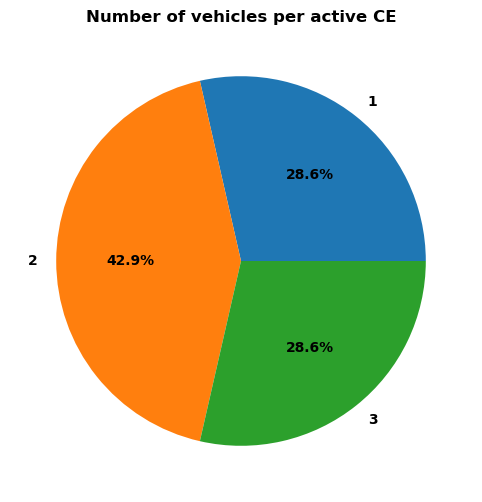

In [ ]:
n_vehic = z3.X.sum(axis=(1, 2))
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

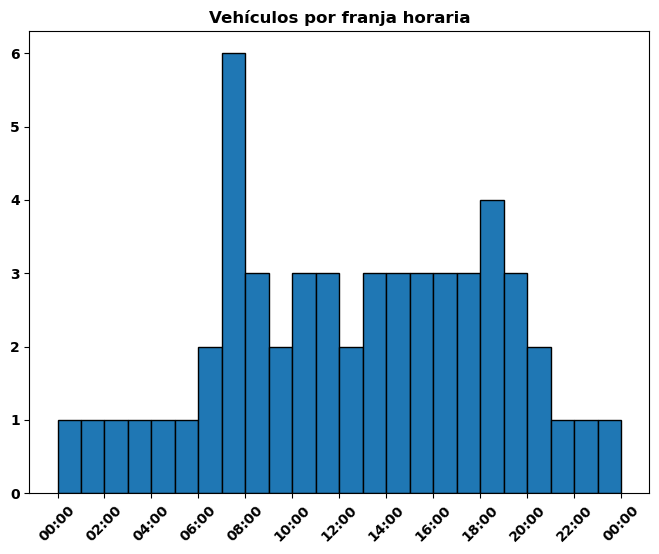

In [ ]:
base_hour = datetime(2023, 1, 1, 0, 0, 0)
arr = np.array([base_hour + timedelta(hours=t) for t in range(T)]).astype('datetime64')
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=np.sort(arr), height=z.X.sum(axis=(0, 1)), width=60./24/60, edgecolor='black', align='edge')
ax.set_title(f'Vehículos por franja horaria')
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 45);

## Max cover with capacity, time and budget constraints (w/ discretization) v2

\begin{align*}
\max &\quad f_j \cdot y_j&\\
s.t. & \quad\frac{1}{N_j}\sum_{i\in R_j,\, t\in T}z_{i, j, t} \geq y_j &\forall j\in J\\
&\sum_{j\in J} z_{i, j, t} \leq K_i &\forall i\in I \, \forall t\in T\\
&\sum_{j\in J,\, t \in T}z_{i, j, t} \leq x_i \tilde{N} & \forall i\in I\\
&\sum_{i\in I} x_i \leq N_{CE}&\\
&\sum_{i\in I,\, j\in J} z_{i, j, t} \geq 0.9 \cdot TP_t \cdot \sum_{j\in J}N_j & \forall t \in T\\
&\sum_{i\in I,\, j\in J} z_{i, j, t} \leq 1.1 \cdot TP_t \cdot \sum_{j\in J}N_j & \forall t \in T\\
&\sum_{i \in I, \, t\in T} z_{i, j, t} \leq N_j & \forall j\in J\\
& x \in \{0, 1\}^I, \, y \in \{0, 1\}^J &\\
& z \in \mathbb{N}^{I\times J\times T}
\end{align*}

Parameters choosen:

* $T = 24$
* $N_{CE} = 165$
* $n_x, n_y$ = 30
* $I = 666$
* $J =333$
* $\sum_{j\in J}N_j = 2527$
* $\tilde{N} = \sum_{j\in J}N_j$

* $f_j = \sum_{j' \in N_j}f_{j'}$

In [9]:
from discretization import D_disc
import pandas as pd
demand_disc_ = Demand(D_disc.apply(lambda x: DemandNode(O=x.O, D=x.D, f=x.f_origin + x.f_dest, tol=x.tol), axis=1).to_numpy())
nodes_disc = pd.concat((D_disc.reset_index()[['O', 'f_origin', 'index', 'N']].rename({'O': 'Node', 'f_origin': 'f', 'index': 'Disc'}, axis=1),
                        D_disc.reset_index()[['D', 'f_dest', 'index', 'N']].rename({'D': 'Node', 'f_dest': 'f', 'index': 'Disc'}, axis=1)))

In [10]:
I = 2 * len(demand_disc_)
J = len(demand_disc_)
T = 24
K = 3 * np.ones(I)
Nce = 165

ub = nodes_disc.N.to_numpy().reshape(I, 1, 1).repeat(J, axis=1).repeat(T, axis=2)

m4 = gp.Model()

# Add variables
x4 = m4.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y4 = m4.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z4 = m4.addMVar(shape=(I, J, T),                        # Assignations
                vtype=gp.GRB.INTEGER,
                name='z',
                lb=np.zeros((I, J, T)),
                ub=ub)

$$
\max f_j \cdot y_j
$$

In [11]:
# Set objective function
#obj4 = gp.quicksum([demand_disc_[j].f * y4[j] for j in range(J)])
obj4 = gp.quicksum([demand_disc_[j].f / (nodes_disc.iloc[j].N) * z4.sum(axis=(0, 2))[j] for j in range(J)])
m4.setObjective(obj4, gp.GRB.MAXIMIZE)

For every travel, the demand is covered if the total amount of cars associated to reachables CEs is the total demand:

$$
\frac{1}{N_j}\sum_{i\in R_j,\, t\in T}z_{i, j, t} \geq y_j \quad \forall j\in J
$$

In [12]:
for j in range(J):
    m4.addConstr(gp.quicksum([z4[i, j, t] for i in demand_disc_[j].reachable_nodes(nodes=nodes_disc).index for t in range(T)]) / nodes_disc.iloc[j].N >= y4[j])

For every CE and at every time, the number of vehicles asociated to a CE is less than its capacity:

$$
\sum_{j\in J} z_{i, j, t} \leq K_i \quad\forall i\in I \, \forall t\in T
$$

In [13]:
for i in range(I):
    for t in range(T):
        m4.addConstr(gp.quicksum([z4[i, j, t] for j in range(J)]) <= 2 * K[i])

$x_i$ is $1$ if there is a vehicle asociated to the $i$-th CE:

$$
\sum_{j\in J,\, t \in T}z_{i, j, t} \leq x_i \sum_{j\in J}N_j\quad \forall i\in I
$$

*($\sum_{j\in J}N_j$ can be replaced by any big number)

In [14]:
N_total = nodes_disc.N.sum()

for i in range(I):
    m4.addConstr(x4[i] * N_total >= gp.quicksum([z4[i, j, t] for j in range(J) for t in range(T)]))

Maximum number of CEs:
$$
\sum_{i\in I} x_i \leq N_{CE}
$$

In [15]:
m4.addConstr(gp.quicksum([x4[i] for i in range(I)]) <= Nce)

<MConstr () *awaiting model update*>

Time distribution of the solution:

$$
0.9 \cdot TP_t \cdot \sum_{j\in J} N_j \leq \sum_{i\in I,\, j\in J} z_{i, j, t} \leq 1.1 \cdot TP_t \cdot \sum_{j\in J} N_j \quad \forall t \in T
$$

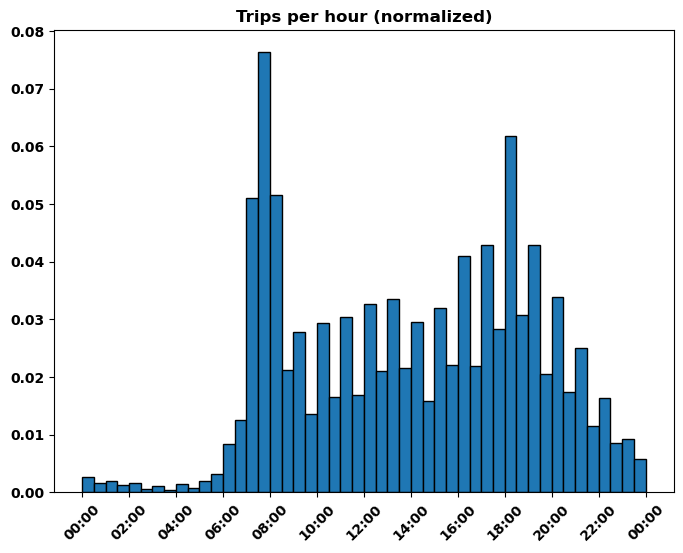

In [17]:
from hist_time import Tp

In [18]:
for t in range(T):
    m4.addConstr((Tp * N_total).astype(int)[t] * 0.9 <= gp.quicksum([z4[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))
    m4.addConstr((Tp * N_total).astype(int)[t] * 1.1 >= gp.quicksum([z4[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))

In [19]:
m4.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17032 rows, 5323671 columns and 21388497 nonzeros
Model fingerprint: 0xc9c613ed
Variable types: 0 continuous, 5323671 integer (999 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+03]
  Objective range  [4e-04, 8e-03]
  Bounds range     [1e+00, 4e+01]
  RHS range        [2e+00, 7e+02]
Found heuristic solution: objective 1.8650571
Presolve removed 333 rows and 192141 columns (presolve time = 5s) ...
Presolve removed 333 rows and 4347027 columns (presolve time = 10s) ...
Presolve removed 333 rows and 4351689 columns (presolve time = 15s) ...
Presolve removed 333 rows and 4351689 columns (presolve time = 20s) ...
Presolve removed 333 rows and 4351689 columns (presolve time = 25s) ...
Presolve removed 333 rows and 4351689 columns (presolve

GurobiError: Out of memory

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes_disc.plot(edgecolor='gray', facecolor='none', alpha=.5, ax=ax, label=f'Demand nodes ({len(nodes_disc)})')
ax.scatter([d.O.x for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({z4.sum() / D_disc.N.sum()})')
ax.scatter([d.D.x for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], color='green')

ax.set_title(f'Covered OD pairs: {(z4.X.sum(axis=(0, 2)) > 0).sum()}/{z4.X.shape[1]}')

nodes_disc[z4.X.sum(axis=(1, 2)) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z4.X.sum(axis=(1, 2)) > 0).sum()})')
        
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

: 

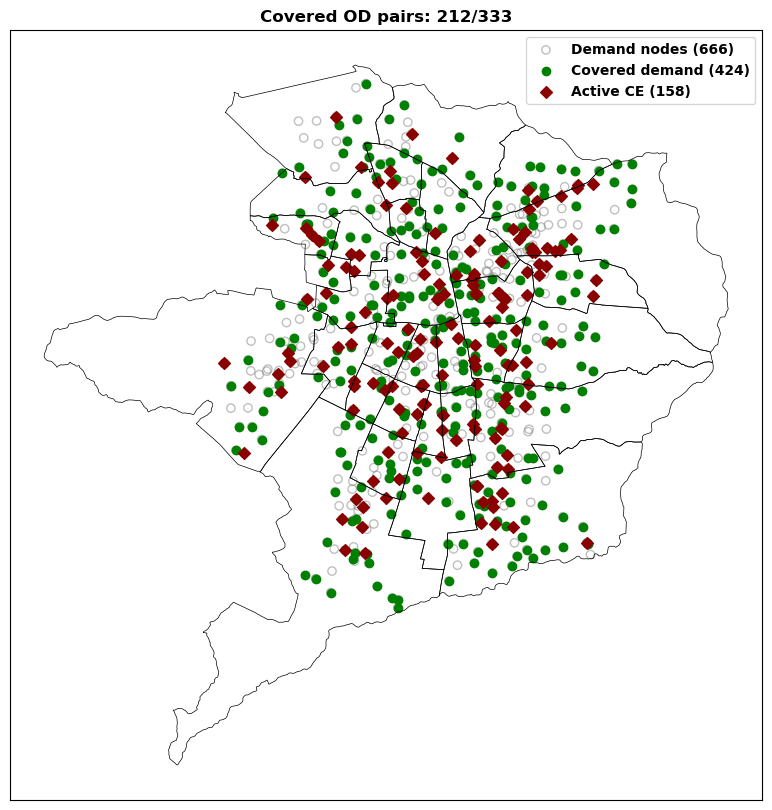

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes_disc.plot(edgecolor='gray', facecolor='none', alpha=.5, ax=ax, label=f'Demand nodes ({len(nodes_disc)})')
ax.scatter([d.O.x for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({2 * (z4.X.sum(axis=(0, 2)) > 0).sum()})')
ax.scatter([d.D.x for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_disc_[z4.X.sum(axis=(0, 2)) > 0]], color='green')

ax.set_title(f'Covered OD pairs: {(z4.X.sum(axis=(0, 2)) > 0).sum()}/{z4.X.shape[1]}')

nodes_disc[z4.X.sum(axis=(1, 2)) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z4.X.sum(axis=(1, 2)) > 0).sum()})')
        
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

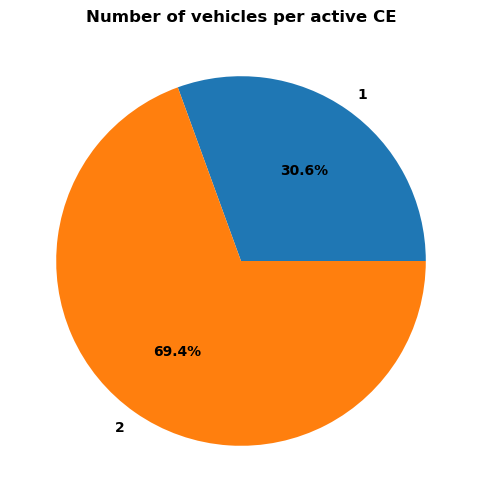

In [39]:
n_vehic = z4.X.sum(axis=(1, 2))
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

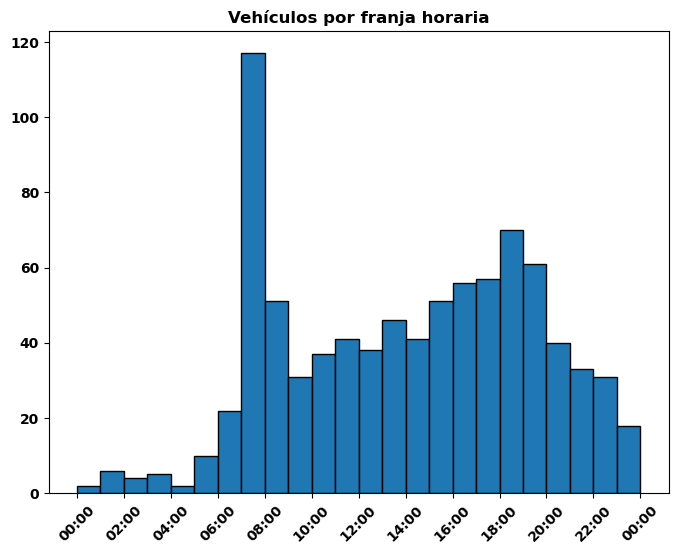

In [40]:
base_hour = datetime(2023, 1, 1, 0, 0, 0)
arr = np.array([base_hour + timedelta(hours=t) for t in range(T)]).astype('datetime64')
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=np.sort(arr), height=z4.X.sum(axis=(0, 1)), width=60./24/60, edgecolor='black', align='edge')
ax.set_title(f'Vehículos por franja horaria')
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 45);

## Max cover with capacity, time and budget constraints (w/ discretization) v3, number of plugs as an decision variable

\begin{align*}
\max &\quad f_j \cdot y_j&\\
s.t. & \quad\frac{1}{N_j}\sum_{i\in R_j,\, t\in T}z_{i, j, t} \geq y_j &\forall j\in J\\
&\sum_{j\in J} z_{i, j, t} \leq 2x_i &\forall i\in I \, \forall t\in T\\
&\sum_{j\in J,\, t \in T}z_{i, j, t} \leq x_i \tilde{N} & \forall i\in I\\
&\sum_{i\in I} x_i \leq N_{P}&\\
&\sum_{i\in I,\, j\in J} z_{i, j, t} \geq 0.9 \cdot TP_t \cdot \sum_{j\in J}N_j & \forall t \in T\\
&\sum_{i\in I,\, j\in J} z_{i, j, t} \leq 1.1 \cdot TP_t \cdot \sum_{j\in J}N_j & \forall t \in T\\
&\sum_{i \in I, \, t\in T} z_{i, j, t} \leq N_j & \forall j\in J\\
& x \in \{0, 1\}^I, \, y \in \{0, 1\}^J &\\
& z \in \mathbb{N}^{I\times J\times T}
\end{align*}

In [43]:
I = 2 * len(demand_disc_)
J = len(demand_disc_)
T = 24
K = 2 * np.ones(I)
Np = 482

m5 = gp.Model()

# Add variables
x5 = m5.addMVar(shape=I,                                # CEs
                vtype=gp.GRB.INTEGER,
                name="x",
                lb=np.zeros(I),
                ub=np.ones(I) * Np)
y5 = m5.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z5 = m5.addMVar(shape=(I, J, T),                        # Assignations
                vtype=gp.GRB.INTEGER,
                name='z',
                lb=np.zeros((I, J, T)),
                ub=ub)

In [44]:
# Set objective function
obj5 = gp.quicksum([demand_disc_[j].f * y5[j] for j in range(J)])
m5.setObjective(obj5, gp.GRB.MAXIMIZE)

$$
\frac{1}{N_j}\sum_{i\in R_j,\, t\in T}z_{i, j, t} \geq y_j \quad\forall j\in J
$$

In [45]:
for j in range(J):
    m5.addConstr(gp.quicksum([z5[i, j, t] for i in demand_disc_[j].reachable_nodes(nodes=nodes_disc).index for t in range(T)]) / nodes_disc.iloc[j].N >= y5[j])

$$
\sum_{j\in J} z_{i, j, t} \leq 2x_i \quad\forall i\in I \, \forall t\in T
$$

In [46]:
for i in range(I):
    for t in range(T):
        m5.addConstr(gp.quicksum([z5[i, j, t] for j in range(J)]) <= 2 * x5[i])

$$
\sum_{j\in J,\, t \in T}z_{i, j, t} \leq x_i \tilde{N} \quad \forall i\in I
$$

In [47]:
N_total = nodes_disc.N.sum()

for i in range(I):
    m5.addConstr(x5[i] * N_total >= gp.quicksum([z5[i, j, t] for j in range(J) for t in range(T)]))

$$
\sum_{i\in I} x_i \leq N_{P}
$$

In [48]:
m5.addConstr(gp.quicksum([x5[i] for i in range(I)]) <= Np)

<MConstr () *awaiting model update*>

$$
0.9 \cdot TP_t \cdot \sum_{j\in J}N_j \leq \sum_{i\in I,\, j\in J} z_{i, j, t} \leq 1.1 \cdot TP_t \cdot \sum_{j\in J}N_j \quad \forall t \in T
$$

In [49]:
for t in range(T):
    m5.addConstr((Tp * N_total).astype(int)[t] * 0.9 <= gp.quicksum([z5[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))
    m5.addConstr((Tp * N_total).astype(int)[t] * 1.1 >= gp.quicksum([z5[i, j, t] * nodes_disc.iloc[j].N for i in range(I) for j in range(J)]))

In [50]:
m5.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17032 rows, 5323671 columns and 21429753 nonzeros
Model fingerprint: 0xfd67b405
Variable types: 0 continuous, 5323671 integer (333 binary)
Coefficient statistics:
  Matrix range     [2e-02, 5e+03]
  Objective range  [4e-04, 3e-01]
  Bounds range     [1e+00, 3e+02]
  RHS range        [6e+00, 7e+02]
Presolve removed 0 rows and 282996 columns (presolve time = 6s) ...
Presolve removed 0 rows and 4767141 columns (presolve time = 10s) ...
Presolve removed 0 rows and 4767141 columns (presolve time = 15s) ...
Presolve removed 0 rows and 4767141 columns (presolve time = 20s) ...
Presolve removed 0 rows and 4767141 columns (presolve time = 25s) ...
Presolve removed 0 rows and 4767141 columns (presolve time = 30s) ...
Presolve added 36 rows and 0 columns
Pres

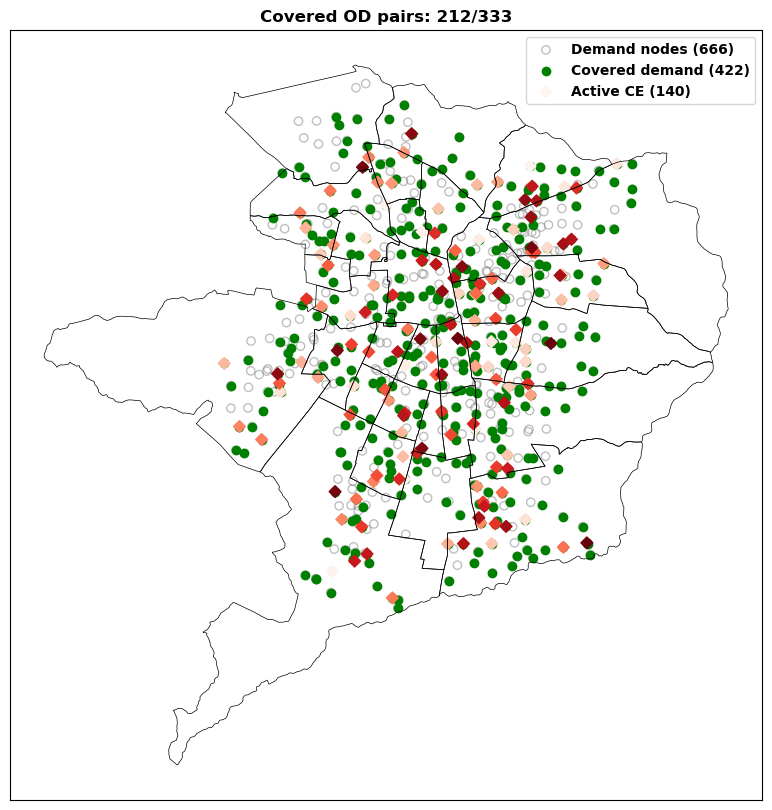

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes_disc.plot(edgecolor='gray', facecolor='none', alpha=.5, ax=ax, label=f'Demand nodes ({len(nodes_disc)})')
ax.scatter([d.O.x for d in demand_disc_[y5.X > 0]], [d.O.y for d in demand_disc_[y5.X > 0]], color='green', label=f'Covered demand ({2 * (y5.X > 0).sum()})')
ax.scatter([d.D.x for d in demand_disc_[y5.X > 0]], [d.D.y for d in demand_disc_[y5.X > 0]], color='green')
#ax.scatter([d.O.x for d in demand_disc_[z5.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_disc_[z5.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({2 * (z5.X.sum(axis=(0, 2)) > 0).sum()})')
#ax.scatter([d.D.x for d in demand_disc_[z5.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_disc_[z5.X.sum(axis=(0, 2)) > 0]], color='green')

ax.set_title(f'Covered OD pairs: {(z4.X.sum(axis=(0, 2)) > 0).sum()}/{z4.X.shape[1]}')

nodes_disc[x5.X > 0].plot(marker='D', ax=ax, label=f'Active CS ({(x5.X > 0).sum()})', c=x5.X, cmap='Reds')
        
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

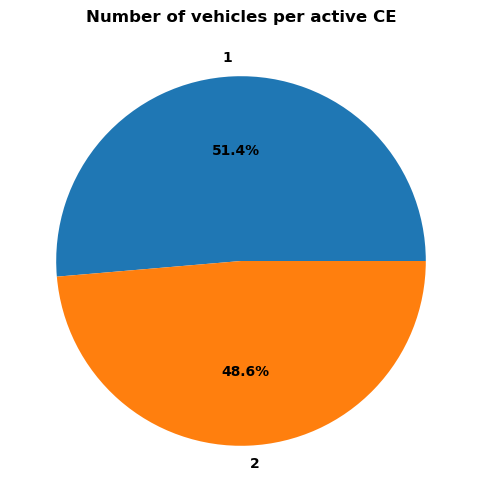

In [63]:
n_vehic = z5.X.sum(axis=(1, 2))
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

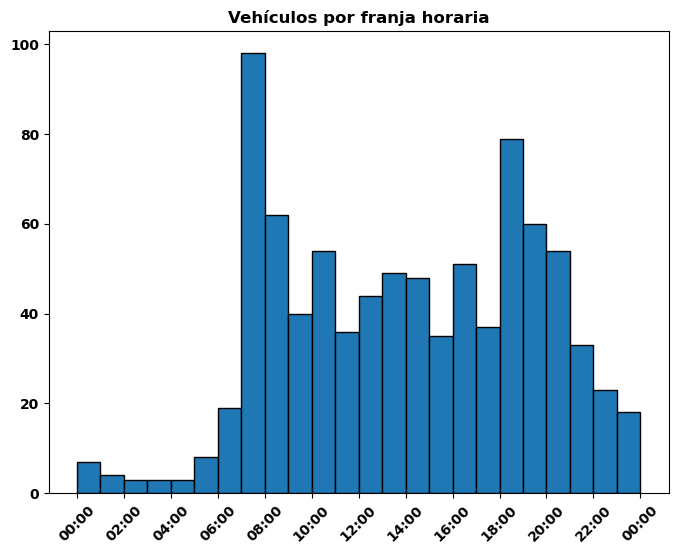

In [64]:
base_hour = datetime(2023, 1, 1, 0, 0, 0)
arr = np.array([base_hour + timedelta(hours=t) for t in range(T)]).astype('datetime64')
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=np.sort(arr), height=z5.X.sum(axis=(0, 1)), width=60./24/60, edgecolor='black', align='edge')
ax.set_title(f'Vehículos por franja horaria')
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 45);

## Max coverage with capacity and time constraints w/o budget constraints

$$
\begin{align*}
\min & \sum_{i\in I} x_i &\\
s.t.\, & \sum_{i\in R_j, \,t \in T} z_{i,j,t} \geq y_j & \forall j \in J\\
&\sum_{j \in J} z_{i,j,t} \leq K_i & \forall i \in I, \, \forall t \in T \\
& \sum_{j \in J, \, t \in T} z_{i,j,t} \leq x_i \cdot J & \forall i \in I\\
& \sum_{j \in J} y_j = |J|\\
& 0.9 \cdot VH_t \leq \sum_{i \in I, \, j \in J} z_{i, j, t} \leq 1.1 \cdot VH_t & \forall t \in T
\end{align*}    
$$

In [ ]:
m = gp.Model()

K = 3 * np.ones(I)
T = 24

# Add variables
x = m.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y = m.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z = m.addMVar(shape=(I, J, T), vtype=gp.GRB.BINARY, name='z') # Assignations

# Set objective function
obj = gp.quicksum([x[i] for i in range(I)])
m.setObjective(obj, gp.GRB.MINIMIZE)

# Set constraints
for j in range(J):
    m.addConstr(gp.quicksum([z[i, j, t] for i in demand_[j].reachable_nodes().index for t in range(T)]) >= y[j])

for i in range(I):
    for t in range(T):
        m.addConstr(gp.quicksum([z[i, j, t] for j in range(J)]) <= K[i])

for i in range(I):    
    m.addConstr(x[i] * J >= gp.quicksum([z[i, j, t] for j in range(J) for t in range(T)]))

m.addConstr(gp.quicksum([y[j] for j in range(J)]) == J)

for t in range(T):
    m.addConstr((J * Tp).astype(int)[t] <= gp.quicksum([z[i, j, t] for i in range(I) for j in range(J)]))
    m.addConstr((J * Tp).astype(int)[t] + 1 >= gp.quicksum([z[i, j, t] for i in range(I) for j in range(J)]))

m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2599 rows, 120150 columns and 488120 nonzeros
Model fingerprint: 0x2f93b644
Variable types: 0 continuous, 120150 integer (120150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 53.0000000
Presolve removed 1780 rows and 110702 columns
Presolve time: 0.22s
Presolved: 819 rows, 9448 columns, 30314 nonzeros
Variable types: 0 continuous, 9448 integer (8020 binary)
Found heuristic solution: objective 38.0000000

Root relaxation: objective 1.000000e+00, 651 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

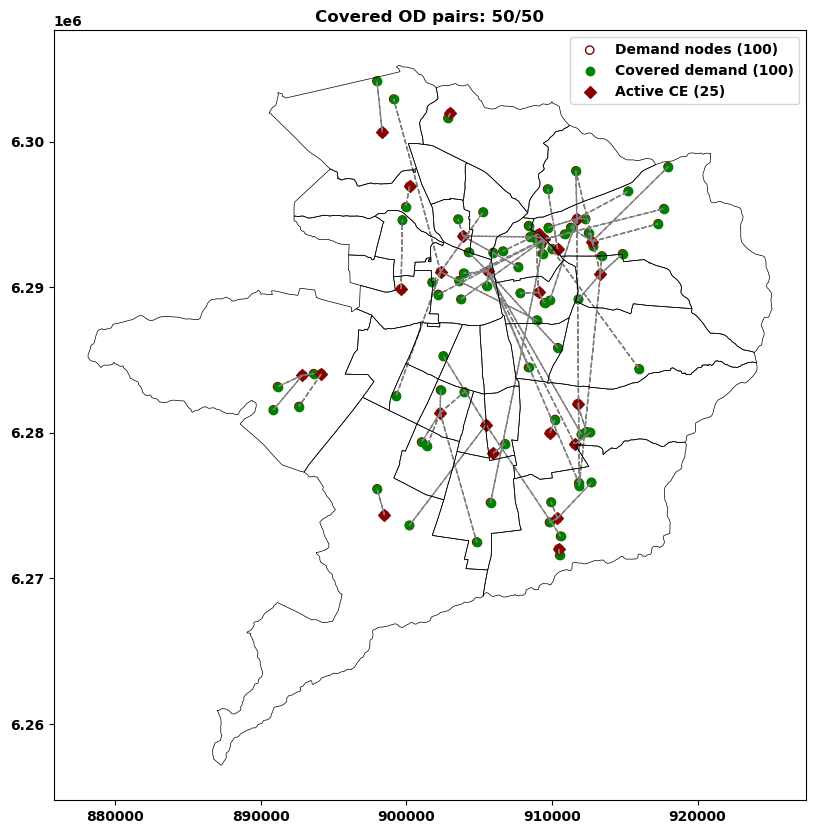

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_[z.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=(0, 2)) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_[z.X.sum(axis=(0, 2)) > 0]], color='green')
nodes[z.X.sum(axis=(1, 2)) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=(1, 2)) > 0).sum()})')

ax.set_title(f'Covered OD pairs: {(z.X.sum(axis=(0, 2)) > 0).sum()}/{z.X.shape[1]}')

for i in range(I):
    for j in range(J):
        if z.X.sum(axis=-1)[i, j] > 0:
            d = demand_[j]
            ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
            ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
        
ax.legend();

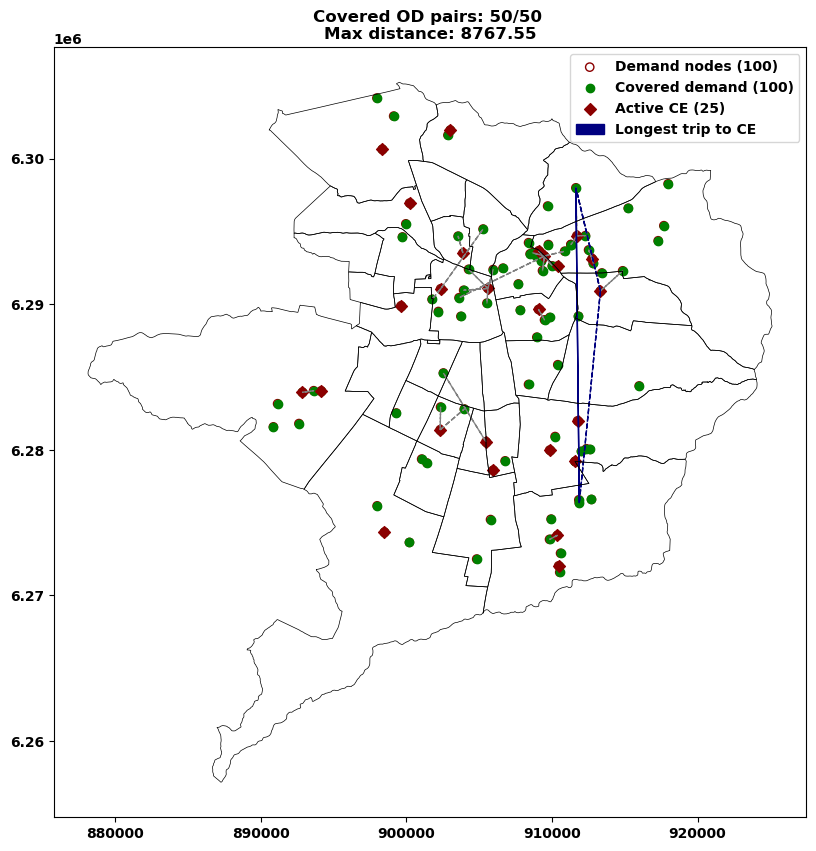

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[z.X.sum(axis=(0, 2)) > 0]], [d.O.y for d in demand_[z.X.sum(axis=(0, 2)) > 0]], color='green', label=f'Covered demand ({2 * (z.X.sum(axis=(0, 2)) > 0).sum()})')
ax.scatter([d.D.x for d in demand_[z.X.sum(axis=(0, 2)) > 0]], [d.D.y for d in demand_[z.X.sum(axis=(0, 2)) > 0]], color='green')
nodes[z.X.sum(axis=(1, 2)) > 0].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({(z.X.sum(axis=(1, 2)) > 0).sum()})')

min_distances = []
for i in range(I):
    for j in range(J):
        if z.X.sum(axis=-1)[i, j] > 0:
            d = demand_[j]
            if manhattan(d.O, nodes.iloc[i].Node) < manhattan(d.D, nodes.iloc[i].Node):
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='gray')
            else:
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='gray')
            min_distances.append(min(manhattan(d.O, nodes.iloc[i].Node), manhattan(d.D, nodes.iloc[i].Node)))

for i in range(I):
    for j in range(J):
        if z.X.sum(axis=-1)[i, j] > 0:
            d = demand_[j]
            if min(manhattan(demand_[j].O, nodes.iloc[i].Node), manhattan(demand_[j].D, nodes.iloc[i].Node)) == max(min_distances):
                ax.arrow(d.O.x, d.O.y, d.D.x  - d.O.x, d.D.y - d.O.y, linestyle='-', color='navy', label='Longest trip to CE')
                ax.arrow(d.O.x, d.O.y, nodes.iloc[i].Node.x  - d.O.x, nodes.iloc[i].Node.y - d.O.y, linestyle='--', color='navy')
                ax.arrow(d.D.x, d.D.y, nodes.iloc[i].Node.x - d.D.x, nodes.iloc[i].Node.y - d.D.y, linestyle='--', color='navy')

ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
        
ax.legend();

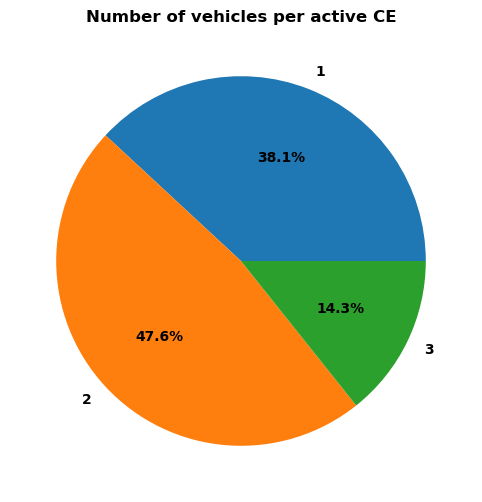

In [ ]:
n_vehic = z.X.sum(axis=(1, 2))
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([(n_vehic == n).sum() for n in range(1, int(K.max()) + 1)], labels=[n for n in range(1, int(K.max()) + 1)], autopct='%1.1f%%')
ax.set_title('Number of vehicles per Active CS');

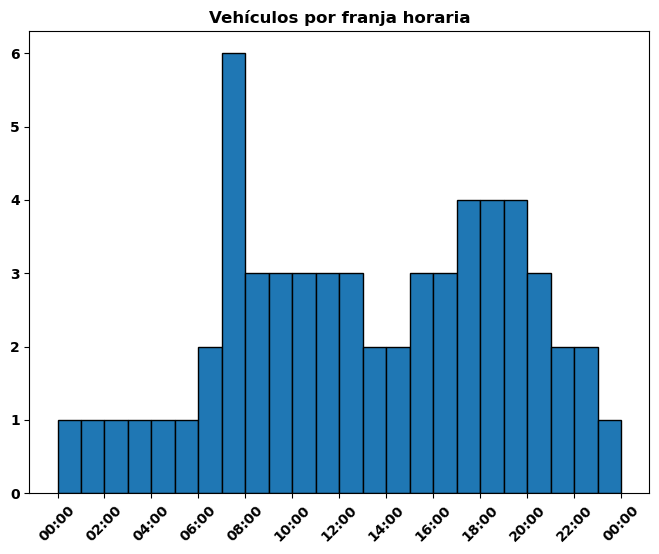

In [ ]:
base_hour = datetime(2023, 1, 1, 0, 0, 0)
arr = np.array([base_hour + timedelta(hours=t) for t in range(T)]).astype('datetime64')
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=np.sort(arr), height=z.X.sum(axis=(0, 1)), width=60./24/60, edgecolor='black', align='edge')
ax.set_title(f'Vehículos por franja horaria')
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 45);

## Grid locations

In [3]:
import pandas as pd
locations = pd.read_csv('Inputs/locations.csv')

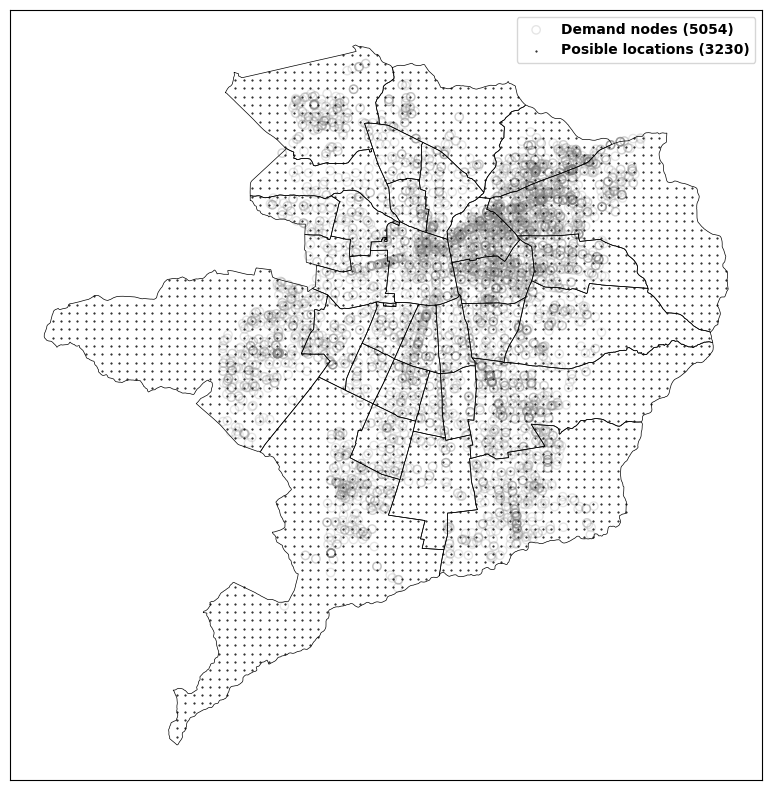

In [4]:
locations = pd.read_csv('Inputs/locations.csv')
locations = gpd.points_from_xy(locations.x, locations.y)
locations = gpd.GeoDataFrame(pd.DataFrame({'Node': locations}), geometry='Node')
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.2, ax=ax, label=f'Demand nodes ({len(nodes)})')
locations.plot(marker='.', color='black', ax=ax, markersize=1, label=f'Posible locations ({len(locations)})')
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

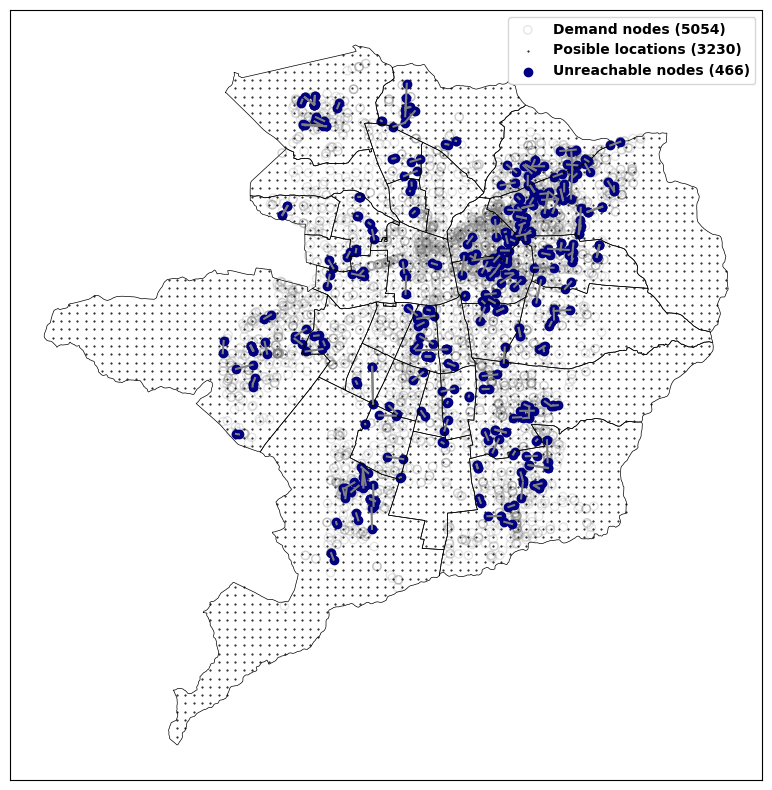

In [5]:
NReachable = np.array([len(demand_[i].reachable_nodes(nodes=locations)) for i in range(len(demand_))])

fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.2, ax=ax, label=f'Demand nodes ({len(nodes)})')
locations.plot(marker='.', color='black', ax=ax, markersize=1, label=f'Posible locations ({len(locations)})')
ax.scatter([d.O.x for d in demand_[NReachable == 0]], [d.O.y for d in demand_[NReachable == 0]], color='navy', label=f'Unreachable nodes ({2 * (NReachable == 0).sum()})')
ax.scatter([d.D.x for d in demand_[NReachable == 0]], [d.D.y for d in demand_[NReachable == 0]], color='navy')

for i in np.where(NReachable == 0)[0]:
    ax.plot([demand_[i].O.x, demand_[i].D.x], [demand_[i].O.y, demand_[i].D.y], color='gray')

ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

The tolerance of short travels is increased, if it's still imposible to satisfy them they are deleted

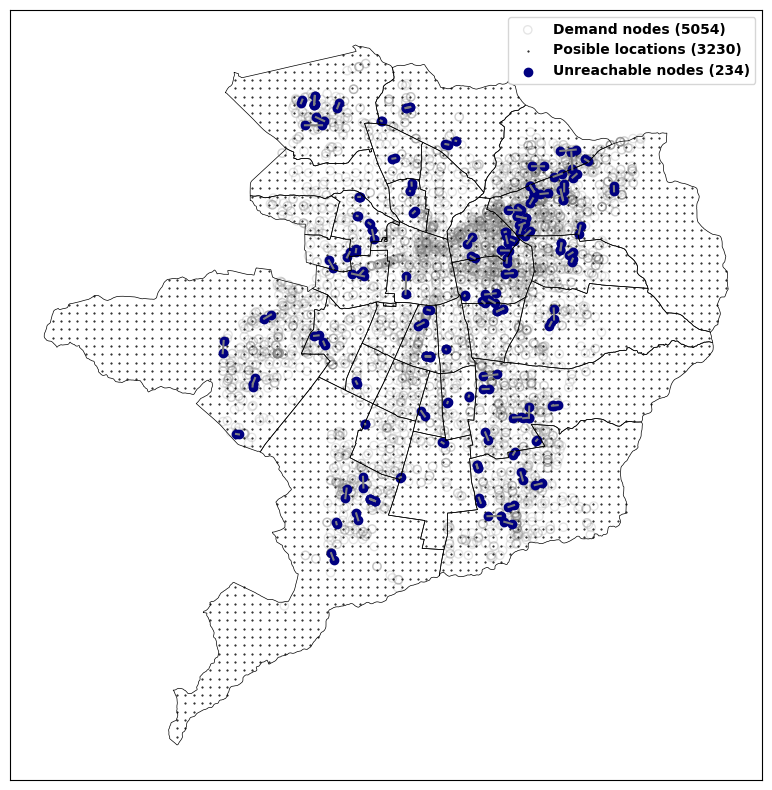

In [6]:
for i in np.where(NReachable == 0)[0]:
    demand_[i].tol = 2 * demand_[i].tol
NReachable = np.array([len(demand_[i].reachable_nodes(nodes=locations)) for i in range(len(demand_))])

fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.2, ax=ax, label=f'Demand nodes ({len(nodes)})')
locations.plot(marker='.', color='black', ax=ax, markersize=1, label=f'Posible locations ({len(locations)})')
ax.scatter([d.O.x for d in demand_[NReachable == 0]], [d.O.y for d in demand_[NReachable == 0]], color='navy', label=f'Unreachable nodes ({2 * (NReachable == 0).sum()})')
ax.scatter([d.D.x for d in demand_[NReachable == 0]], [d.D.y for d in demand_[NReachable == 0]], color='navy')

for i in np.where(NReachable == 0)[0]:
    ax.plot([demand_[i].O.x, demand_[i].D.x], [demand_[i].O.y, demand_[i].D.y], color='gray')

ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

In [7]:
demand_ = demand_[NReachable > 0]

In [ ]:
from hist_time import Tp
Tp = Tp[::2] + Tp[1::2]

I = len(locations)
J = len(demand_)
T = len(Tp)
K = 3 * np.ones(I)
Nce = 165

m4 = gp.Model()

# Add variables
x4 = m4.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x") # CEs
y4 = m4.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y") # Travels
z4 = m4.addMVar(shape=(I, J, T), vtype=gp.GRB.BINARY, name='z') # Assignations

In [9]:
# Set objective function
obj4 = gp.quicksum([demand_[j].f * y4[j] for j in range(J)])

In [10]:
for j in range(J):
    m4.addConstr(gp.quicksum([z4[i, j, t] for i in demand_[j].reachable_nodes(nodes=locations).index for t in range(T)]) >= y4[j])

In [11]:
for i in range(I):
    for t in range(T):
        m4.addConstr(gp.quicksum([z4[i, j, t] for j in range(J)]) <= 2 * int(24/T) * K[i])

In [12]:
for i in range(I):
    m4.addConstr(x4[i] * J >= gp.quicksum([z4[i, j, t] for j in range(J) for t in range(T)]))

In [13]:
m4.addConstr(gp.quicksum([x4[i] for i in range(I)]) <= Nce)

<MConstr () *awaiting model update*>

In [14]:
for t in range(T):
    m4.addConstr((Tp * J).astype(int)[t] * 0.9 <= gp.quicksum([z4[i, j, t] for i in range(I) for j in range(J)]))
    m4.addConstr((Tp * J).astype(int)[t] * 1.1 >= gp.quicksum([z4[i, j, t] for i in range(I) for j in range(J)]))

In [ ]:
m4.optimize()

## Genetic algorithm results

In [ ]:
import pandas as pd
import numpy as np

from GAMixModel_var2 import reachablemask, y, x

report = pd.read_csv('deap_v1/Sol_report(3).csv')
with open('deap_v1/Sol(3).npy', 'rb') as f:
    deap_sol = np.load(f)

z = deap_sol[0]
_y = y(z)
_x = x(z)

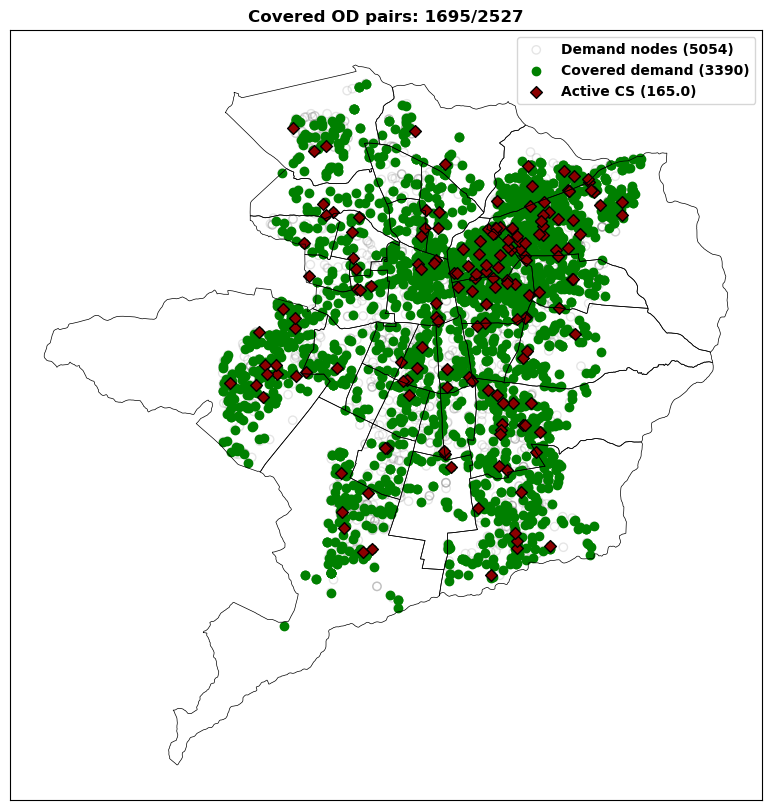

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray', facecolor='none', alpha=.2, ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[_y.astype(bool)]], [d.O.y for d in demand_[_y.astype(bool)]], color='green', label=f'Covered demand ({2 * sum(_y)})')
ax.scatter([d.D.x for d in demand_[_y.astype(bool)]], [d.D.y for d in demand_[_y.astype(bool)]], color='green')

ax.set_title(f'Covered OD pairs: {sum(_y)}/{len(demand_)}')

nodes[_x.astype(bool)].plot(facecolor='darkred', edgecolor='black', marker='D', ax=ax, label=f'Active CS ({_x.sum()})')
        
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

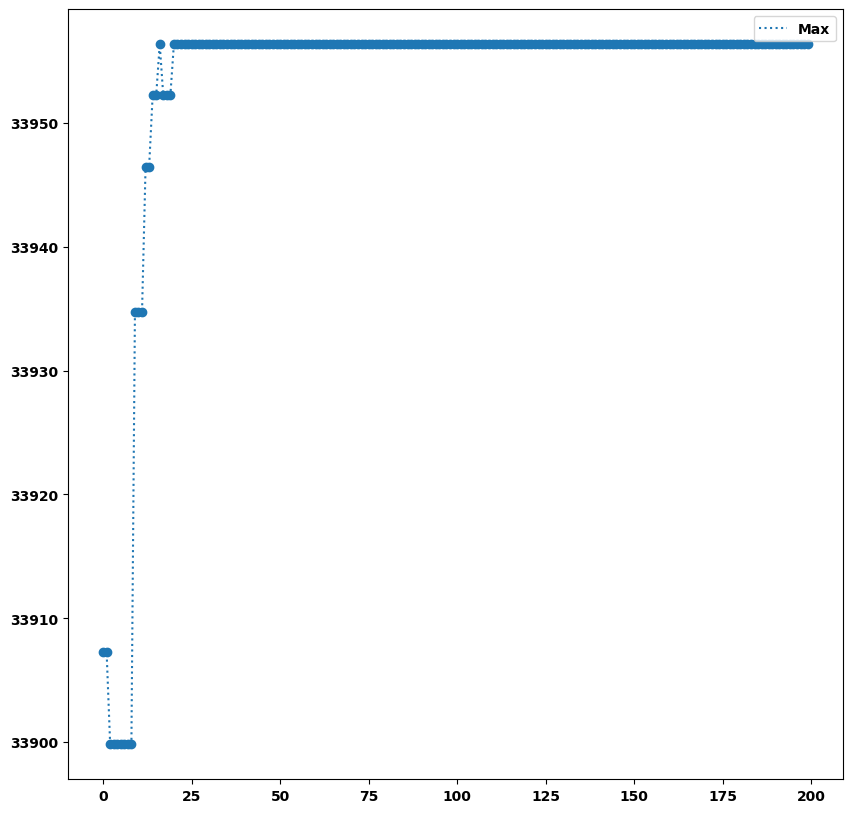

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
#report.Avg.plot(ax=ax, label='Average')
report.Max.plot(ax=ax, label='Max', linestyle='dotted')
ax.scatter(report.Max.index, report.Max)
ax.legend();

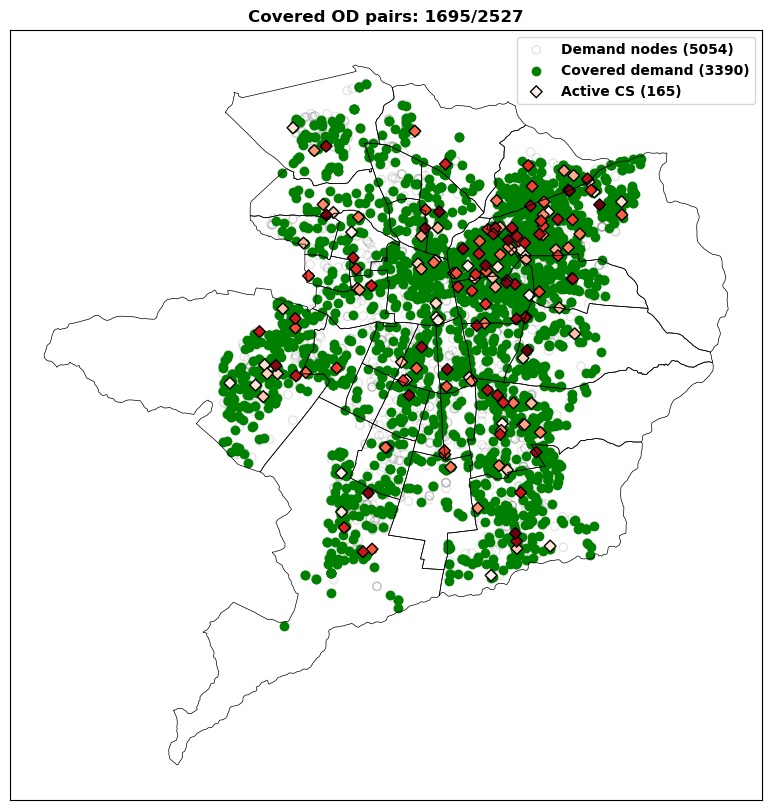

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='gray',
           facecolor='none',
           alpha=.2,
           ax=ax,
           label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.O.x for d in demand_[_y.astype(bool)]],
           [d.O.y for d in demand_[_y.astype(bool)]],
           color='green', label=f'Covered demand ({2 * sum(_y)})')
ax.scatter([d.D.x for d in demand_[_y.astype(bool)]],
           [d.D.y for d in demand_[_y.astype(bool)]],
           color='green')

ax.set_title(f'Covered OD pairs: {sum(_y)}/{len(demand_)}')

nodes[_x.astype(bool)].plot(cmap='Reds',
                            edgecolor='black',
                            marker='D',
                            ax=ax,
                            label=f'Active CS ({int(_x.sum())})',
                            c=[(z[:, 1] == i).sum() \
                               for i in np.arange(len(_x))[_x.astype(bool)]])
        
ax.legend()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([]);

In [9]:
from GAMixModel_var2 import capacity, x, Tp, T

Capacity constrint

In [10]:
capacity(z)[:, _x.astype(int)].min(axis=0)

array([10., 10., 10., ..., 10., 11., 10.])

Vehicles charging per hour

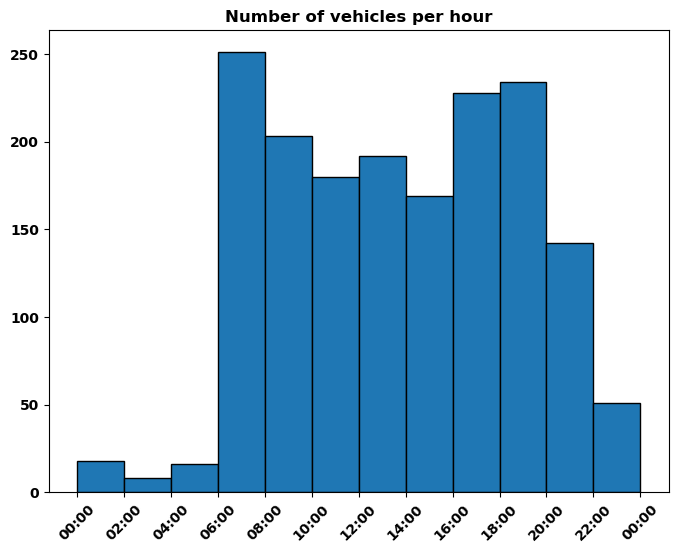

In [24]:
base_hour = datetime(2023, 1, 1, 0, 0, 0)
arr = np.array([base_hour + 2*timedelta(hours=t) for t in range(T)]).astype('datetime64')
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=np.sort(arr),
       height=np.unique(z[:, 2], return_counts=True)[1][:12],
       width=120./24/60,
       edgecolor='black',
       align='edge')
ax.set_title(f'Number of vehicles per hour')
hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 45);

## Paths

In [ ]:
demand_.get_paths()

In [ ]:
m2 = gp.Model()
M = 1e10

# Distances
dists = {(i, j): manhattan(nodes.iloc[i].Node, nodes.iloc[j].Node) \
         for i in range(len(nodes)) \
            for j in range(len(nodes))}

# Add variables
x = m2.addMVar(shape=I, vtype=gp.GRB.BINARY, name="x")
y = m2.addMVar(shape=J, vtype=gp.GRB.BINARY, name="y")
d = m2.addVar(vtype=gp.GRB.CONTINUOUS, name='d')
daux = m2.addMVar(shape=(I, J), vtype=gp.GRB.CONTINUOUS, name='daux')
#daux2 = m2.addMVar(shape=(I, J), vtype=gp.GRB.CONTINUOUS, name='daux2')
aux = m2.addMVar(shape=J, vtype=gp.GRB.CONTINUOUS, name='aux')
aux2 = m2.addMVar(shape=J, vtype=gp.GRB.CONTINUOUS, name='aux2')
# Set objective function
m2.setObjective(gp.quicksum([d[i, j] * y[j] for i in range(I) for j in range(J)]), gp.GRB.MINIMIZE)

# Set constraints
for j in range(J):
    m2.addConstr(gp.quicksum([x[i] for i in demand_[j].reachable_nodes().index]) >= y[j])

m2.addConstr(gp.quicksum([x[i] for i in range(I)]) <= Nce)

for i in range(I):
    for j in range(J):
        m2.addConstr(daux[i, j] == dists[i, j] + (1 - x[i]) * M)

for j in range(J):
    m2.addConstr(aux[j] == gp.min_([daux[i, j] for i in demand_[j].reachable_nodes().index]))

for j in range(J):
    m2.addConstr(d >= aux[j] * y[j])


m2.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5051 rows, 5251 columns and 10480 nonzeros
Model fingerprint: 0x8fb7dd23
Model has 50 quadratic constraints
Model has 50 general constraints
Variable types: 5101 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [7e-04, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 4620 rows and 4390 columns
Presolve time: 0.01s
Presolved: 581 rows, 1011 columns, 2150 nonzeros
Presolved model has 430 SOS constraint(s)
Variable types: 480 continuous, 531 integer (530 binary)

Root rela

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\benja\anaconda3\envs\geo_env\Lib\site-packages\ipykernel\iostream.py", line 535, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


*72603  1293             122       0.0000000    0.00000  0.00%   1.7    2s

Cutting planes:
  Implied bound: 25

Explored 72979 nodes (121726 simplex iterations) in 2.92 seconds (1.20 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 0 0.00321849 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


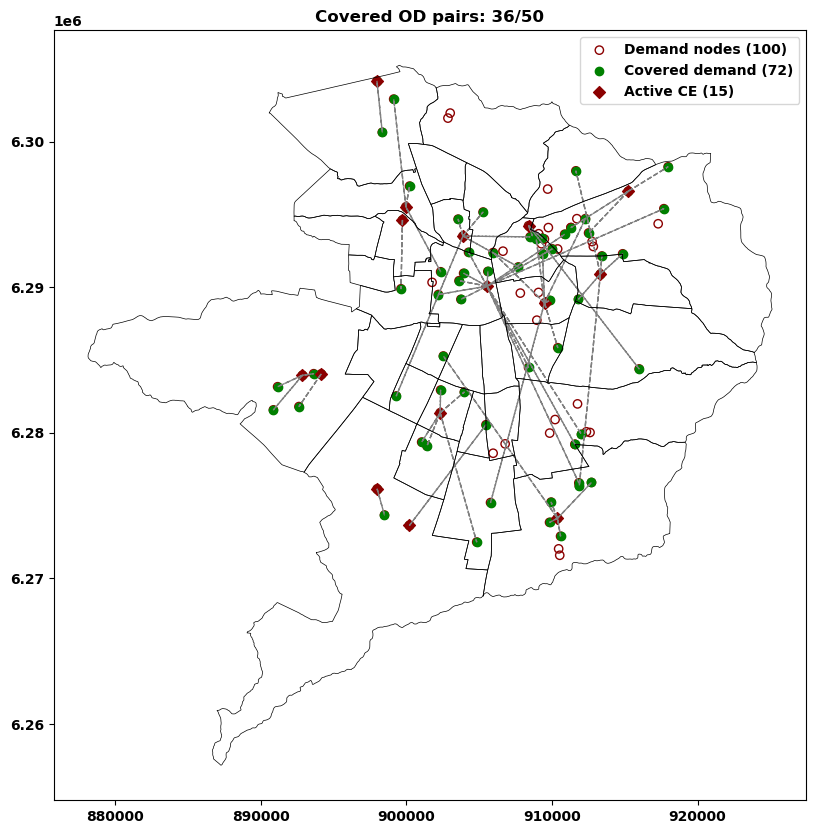

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')
ax.set_title(f'Covered OD pairs: {int(y.X.sum())}/{len(y.X)}')
for i, d in enumerate(demand_):
    if y.X[i] == 1:
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances = np.array([manhattan(d.O, m) + manhattan(d.D, m) for m in matches])
        closest_match = matches[np.argmin(match_distances)]
        ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
ax.legend();

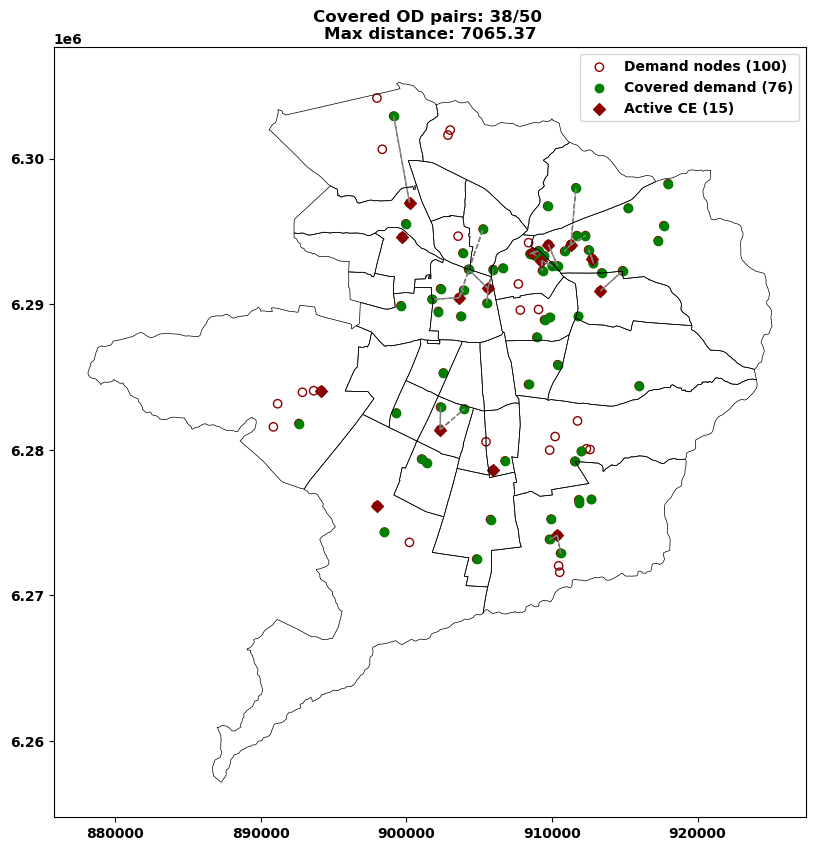

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
santiago_map.boundary.plot(ax=ax, color='black', linewidth=.5)
nodes.plot(edgecolor='darkred', facecolor='none', ax=ax, label=f'Demand nodes ({len(nodes)})')
ax.scatter([d.x for d in D.O[y.X.astype(bool)]], [d.y for d in D.O[y.X.astype(bool)]], color='green', label=f'Covered demand ({2 * int(y.X.sum())})')
ax.scatter([d.x for d in D.D[y.X.astype(bool)]], [d.y for d in D.D[y.X.astype(bool)]], color='green')
nodes[x.X.astype(bool)].plot(color='darkred', marker='D', ax=ax, label=f'Active CS ({int(x.X.sum())})')

min_distances = []
for i, d in enumerate(demand_):
    if y.X[i] == 1:
        active_mask = x.X.astype(bool)
        reachable_mask = np.zeros(len(nodes), dtype=bool)
        reachable_mask[d.reachable_nodes().index] = True
        matches = nodes[reachable_mask & active_mask].reset_index().Node
        match_distances_O = np.array([manhattan(d.O, m) for m in matches])
        match_distances_D = np.array([manhattan(d.D, m) for m in matches])
        if match_distances_O.min() < match_distances_D.min():
            closest_match = matches[np.argmin(match_distances_O)]
            ax.arrow(d.O.x, d.O.y, closest_match.x - d.O.x, closest_match.y - d.O.y, linestyle='--', color='gray')
        else:
            closest_match = matches[np.argmin(match_distances_D)]
            ax.arrow(d.D.x, d.D.y, closest_match.x - d.D.x, closest_match.y - d.D.y, linestyle='--', color='gray')
        min_distances.append(min(manhattan(d.O, closest_match), manhattan(d.D, closest_match)))
ax.set_title('Covered OD pairs: {}/{} \nMax distance: {:.2f}'.format(int(y.X.sum()), len(y.X), max(min_distances)))
ax.legend();